In [26]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import gc

%matplotlib inline
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000
pd.options.display.max_seq_items = 1000

## Load Data

In [2]:
exceptional_days = pd.read_csv("exceptional_days.txt",parse_dates=['date'])
actions = pd.read_csv('../input/dailyProductActions.csv',parse_dates=['date'])
products = pd.read_csv('../input/product.csv')

In [3]:
submission = pd.read_csv('../input/SampleSubmission.csv')

### Generate Features for Train set

In [4]:
actions['saleDay'] = 0
actions["week"] = pd.DatetimeIndex(actions["date"]).weekofyear
actions.loc[actions[actions.date.isin(exceptional_days.date.unique())].index,'saleDay'] = 1
actions.loc[actions["week"] == 2, "week"] = 11
actions.loc[actions["week"] == 1, "week"] = 10
actions.loc[actions["week"] == 52, "week"] = 9
actions.loc[actions["week"] == 51, "week"] = 8
actions.loc[actions["week"] == 50, "week"] = 7
actions.loc[actions["week"] == 49, "week"] = 6
actions.loc[actions["week"] == 48, "week"] = 5
actions.loc[actions["week"] == 47, "week"] = 4
actions.loc[actions["week"] == 46, "week"] = 3
actions.loc[actions["week"] == 45, "week"] = 2
actions.loc[actions["week"] == 44, "week"] = 1
actions.fillna(0, inplace=True)

In [5]:
weekly = (actions.groupby(["productid", "week"], as_index=False)
             .agg({'saleDay':'sum', 'stock':'mean', 'clickcount':'sum','favoredcount':'sum', 'soldquantity':'sum', }).sort_values('week'))

In [6]:
product_means = (weekly.groupby(["productid"], as_index=False)
               .agg({'soldquantity':'mean','stock':'mean','clickcount':'mean','favoredcount':'mean'})
               .rename(columns={'soldquantity':'soldquantitymean','stock':'stockmean','clickcount':'clickcountmean','favoredcount':'favoredcountmean'}))
product_means.set_index("productid", inplace=True)

In [7]:
train_set = pd.DataFrame(index=list(products['productid']))

In [8]:
for row in tqdm(weekly.itertuples()):
    train_set.at[row[1], 'prior_week_'        + str(row[2])] = 1
    train_set.at[row[1], 'saleday_week_'      + str(row[2])] = row[3]
    train_set.at[row[1], 'stock_week_'        + str(row[2])] = row[4]
    train_set.at[row[1], 'clickcount_week_'   + str(row[2])] = row[5]
    train_set.at[row[1], 'favoredcount_week_' + str(row[2])] = row[6]
    train_set.at[row[1], 'soldquantity_week_' + str(row[2])] = row[7]

1502532it [01:41, 14759.32it/s]


In [9]:
products['female'] = 0
products['male'] = 0
products.loc[products[(products.gender==2)|(products.gender==3)].index,'female'] = 1
products.loc[products[(products.gender==1)|(products.gender==3)].index,'male'] = 1
products.drop(columns=['gender'],inplace=True)

In [10]:
train_set = pd.concat([product_means, train_set], axis=1, join='inner')
train_set = pd.concat([products.set_index('productid'), train_set], axis=1, join='inner')
train_set.reset_index(inplace=True)
train_set.rename(columns={'index':'productid'},inplace=True)
train_set.fillna(0, inplace=True)

In [11]:
del product_means, weekly, actions, products, exceptional_days
gc.collect()

233

### Merge features into test data

In [12]:
submission = submission.merge(train_set,how='left',on=['productid'])

In [13]:
submission.drop(columns=['sales','soldquantity_week_11'], inplace=True)

### Train set/ Test set split 

In [14]:
y = train_set['soldquantity_week_11']

In [15]:
colsToTrain = train_set.drop(['soldquantity_week_11'], axis=1)
X = colsToTrain

In [16]:
print('X.shape = ' + str(X.shape))
print('y.shape = ' + str(y.shape))

X.shape = (193731, 77)
y.shape = (193731,)


In [17]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(X, y,
                                                      random_state=6,
                                                      test_size=0.10)

In [18]:
X_test = submission.copy()

In [19]:
del colsToTrain, train_set, X, y , submission
gc.collect()

14

### Model parameters 

In [20]:
import xgboost as xgb
model = xgb.XGBRegressor(objective = 'reg:linear',
                         metric = 'rmse',
                         n_estimators = 13500,
                         max_depth = 6,
                         learning_rate = 0.001,
                         tree_method = 'gpu_hist',
                         verbosity = 0)

### Model train 

In [21]:
model.fit(x_train,y_train,
          eval_metric='rmse',
          eval_set=[(x_train, y_train), (x_valid, y_valid)])

[0]	validation_0-rmse:4.86325	validation_1-rmse:5.79907
[1]	validation_0-rmse:4.85958	validation_1-rmse:5.79563
[2]	validation_0-rmse:4.8559	validation_1-rmse:5.79219
[3]	validation_0-rmse:4.85223	validation_1-rmse:5.78876
[4]	validation_0-rmse:4.84857	validation_1-rmse:5.78533
[5]	validation_0-rmse:4.84491	validation_1-rmse:5.78191
[6]	validation_0-rmse:4.84125	validation_1-rmse:5.77849
[7]	validation_0-rmse:4.8376	validation_1-rmse:5.77507
[8]	validation_0-rmse:4.83395	validation_1-rmse:5.77166
[9]	validation_0-rmse:4.83031	validation_1-rmse:5.76825
[10]	validation_0-rmse:4.82667	validation_1-rmse:5.76485
[11]	validation_0-rmse:4.82304	validation_1-rmse:5.76145
[12]	validation_0-rmse:4.8194	validation_1-rmse:5.75805
[13]	validation_0-rmse:4.81578	validation_1-rmse:5.75466
[14]	validation_0-rmse:4.81216	validation_1-rmse:5.75127
[15]	validation_0-rmse:4.80854	validation_1-rmse:5.74789
[16]	validation_0-rmse:4.80492	validation_1-rmse:5.74451
[17]	validation_0-rmse:4.80132	validation_1-

[144]	validation_0-rmse:4.37161	validation_1-rmse:5.34141
[145]	validation_0-rmse:4.36846	validation_1-rmse:5.33853
[146]	validation_0-rmse:4.36528	validation_1-rmse:5.33567
[147]	validation_0-rmse:4.3621	validation_1-rmse:5.33262
[148]	validation_0-rmse:4.35894	validation_1-rmse:5.32972
[149]	validation_0-rmse:4.35578	validation_1-rmse:5.32685
[150]	validation_0-rmse:4.35262	validation_1-rmse:5.32399
[151]	validation_0-rmse:4.34947	validation_1-rmse:5.32109
[152]	validation_0-rmse:4.3463	validation_1-rmse:5.31806
[153]	validation_0-rmse:4.34315	validation_1-rmse:5.31517
[154]	validation_0-rmse:4.34001	validation_1-rmse:5.31233
[155]	validation_0-rmse:4.33687	validation_1-rmse:5.30948
[156]	validation_0-rmse:4.33374	validation_1-rmse:5.3066
[157]	validation_0-rmse:4.33058	validation_1-rmse:5.30351
[158]	validation_0-rmse:4.32746	validation_1-rmse:5.30072
[159]	validation_0-rmse:4.32433	validation_1-rmse:5.29789
[160]	validation_0-rmse:4.3212	validation_1-rmse:5.29505
[161]	validation_0

[286]	validation_0-rmse:3.95069	validation_1-rmse:4.95039
[287]	validation_0-rmse:3.94797	validation_1-rmse:4.94797
[288]	validation_0-rmse:3.9452	validation_1-rmse:4.94522
[289]	validation_0-rmse:3.94243	validation_1-rmse:4.94247
[290]	validation_0-rmse:3.93972	validation_1-rmse:4.94003
[291]	validation_0-rmse:3.93696	validation_1-rmse:4.93736
[292]	validation_0-rmse:3.93425	validation_1-rmse:4.93498
[293]	validation_0-rmse:3.93145	validation_1-rmse:4.93167
[294]	validation_0-rmse:3.9287	validation_1-rmse:4.92894
[295]	validation_0-rmse:3.926	validation_1-rmse:4.92653
[296]	validation_0-rmse:3.92325	validation_1-rmse:4.92379
[297]	validation_0-rmse:3.92055	validation_1-rmse:4.9214
[298]	validation_0-rmse:3.91781	validation_1-rmse:4.91875
[299]	validation_0-rmse:3.91512	validation_1-rmse:4.91636
[300]	validation_0-rmse:3.91238	validation_1-rmse:4.91363
[301]	validation_0-rmse:3.90965	validation_1-rmse:4.91103
[302]	validation_0-rmse:3.90696	validation_1-rmse:4.90864
[303]	validation_0-

[428]	validation_0-rmse:3.58265	validation_1-rmse:4.5985
[429]	validation_0-rmse:3.58022	validation_1-rmse:4.596
[430]	validation_0-rmse:3.57779	validation_1-rmse:4.59426
[431]	validation_0-rmse:3.5754	validation_1-rmse:4.59209
[432]	validation_0-rmse:3.573	validation_1-rmse:4.5899
[433]	validation_0-rmse:3.57062	validation_1-rmse:4.58774
[434]	validation_0-rmse:3.56819	validation_1-rmse:4.58526
[435]	validation_0-rmse:3.56578	validation_1-rmse:4.58353
[436]	validation_0-rmse:3.5634	validation_1-rmse:4.5814
[437]	validation_0-rmse:3.56098	validation_1-rmse:4.57889
[438]	validation_0-rmse:3.55857	validation_1-rmse:4.57716
[439]	validation_0-rmse:3.5562	validation_1-rmse:4.57503
[440]	validation_0-rmse:3.55384	validation_1-rmse:4.57289
[441]	validation_0-rmse:3.55145	validation_1-rmse:4.57072
[442]	validation_0-rmse:3.54909	validation_1-rmse:4.5686
[443]	validation_0-rmse:3.54668	validation_1-rmse:4.56608
[444]	validation_0-rmse:3.5443	validation_1-rmse:4.5644
[445]	validation_0-rmse:3.5

[570]	validation_0-rmse:3.26272	validation_1-rmse:4.30793
[571]	validation_0-rmse:3.26062	validation_1-rmse:4.306
[572]	validation_0-rmse:3.2585	validation_1-rmse:4.30377
[573]	validation_0-rmse:3.2564	validation_1-rmse:4.30216
[574]	validation_0-rmse:3.25434	validation_1-rmse:4.30036
[575]	validation_0-rmse:3.25223	validation_1-rmse:4.2982
[576]	validation_0-rmse:3.25018	validation_1-rmse:4.29639
[577]	validation_0-rmse:3.24807	validation_1-rmse:4.2942
[578]	validation_0-rmse:3.24598	validation_1-rmse:4.29269
[579]	validation_0-rmse:3.24387	validation_1-rmse:4.29047
[580]	validation_0-rmse:3.24178	validation_1-rmse:4.28845
[581]	validation_0-rmse:3.23973	validation_1-rmse:4.28665
[582]	validation_0-rmse:3.23764	validation_1-rmse:4.28451
[583]	validation_0-rmse:3.23556	validation_1-rmse:4.28291
[584]	validation_0-rmse:3.23353	validation_1-rmse:4.28113
[585]	validation_0-rmse:3.23149	validation_1-rmse:4.27936
[586]	validation_0-rmse:3.2294	validation_1-rmse:4.27724
[587]	validation_0-rm

[712]	validation_0-rmse:2.98448	validation_1-rmse:4.05005
[713]	validation_0-rmse:2.98265	validation_1-rmse:4.04828
[714]	validation_0-rmse:2.98079	validation_1-rmse:4.04647
[715]	validation_0-rmse:2.97899	validation_1-rmse:4.045
[716]	validation_0-rmse:2.9772	validation_1-rmse:4.04336
[717]	validation_0-rmse:2.97534	validation_1-rmse:4.04152
[718]	validation_0-rmse:2.97355	validation_1-rmse:4.03989
[719]	validation_0-rmse:2.97171	validation_1-rmse:4.03845
[720]	validation_0-rmse:2.96988	validation_1-rmse:4.03664
[721]	validation_0-rmse:2.96806	validation_1-rmse:4.03535
[722]	validation_0-rmse:2.96624	validation_1-rmse:4.03355
[723]	validation_0-rmse:2.96441	validation_1-rmse:4.03174
[724]	validation_0-rmse:2.96259	validation_1-rmse:4.03018
[725]	validation_0-rmse:2.96075	validation_1-rmse:4.02838
[726]	validation_0-rmse:2.95897	validation_1-rmse:4.02678
[727]	validation_0-rmse:2.95715	validation_1-rmse:4.02536
[728]	validation_0-rmse:2.95535	validation_1-rmse:4.02361
[729]	validation_

[854]	validation_0-rmse:2.74168	validation_1-rmse:3.82449
[855]	validation_0-rmse:2.74012	validation_1-rmse:3.82301
[856]	validation_0-rmse:2.73852	validation_1-rmse:3.82139
[857]	validation_0-rmse:2.73696	validation_1-rmse:3.81997
[858]	validation_0-rmse:2.73539	validation_1-rmse:3.81865
[859]	validation_0-rmse:2.73384	validation_1-rmse:3.81718
[860]	validation_0-rmse:2.73226	validation_1-rmse:3.81599
[861]	validation_0-rmse:2.73066	validation_1-rmse:3.81438
[862]	validation_0-rmse:2.72912	validation_1-rmse:3.81291
[863]	validation_0-rmse:2.72755	validation_1-rmse:3.81173
[864]	validation_0-rmse:2.72596	validation_1-rmse:3.80981
[865]	validation_0-rmse:2.72442	validation_1-rmse:3.80843
[866]	validation_0-rmse:2.72288	validation_1-rmse:3.80697
[867]	validation_0-rmse:2.72132	validation_1-rmse:3.80547
[868]	validation_0-rmse:2.71975	validation_1-rmse:3.8039
[869]	validation_0-rmse:2.71819	validation_1-rmse:3.80279
[870]	validation_0-rmse:2.71665	validation_1-rmse:3.80135
[871]	validatio

[996]	validation_0-rmse:2.53214	validation_1-rmse:3.63399
[997]	validation_0-rmse:2.53075	validation_1-rmse:3.63305
[998]	validation_0-rmse:2.52937	validation_1-rmse:3.63206
[999]	validation_0-rmse:2.52803	validation_1-rmse:3.6309
[1000]	validation_0-rmse:2.52665	validation_1-rmse:3.6292
[1001]	validation_0-rmse:2.52528	validation_1-rmse:3.62827
[1002]	validation_0-rmse:2.52387	validation_1-rmse:3.62727
[1003]	validation_0-rmse:2.52252	validation_1-rmse:3.62608
[1004]	validation_0-rmse:2.52115	validation_1-rmse:3.62439
[1005]	validation_0-rmse:2.51976	validation_1-rmse:3.62345
[1006]	validation_0-rmse:2.51838	validation_1-rmse:3.62254
[1007]	validation_0-rmse:2.51704	validation_1-rmse:3.62137
[1008]	validation_0-rmse:2.51567	validation_1-rmse:3.61968
[1009]	validation_0-rmse:2.51431	validation_1-rmse:3.61874
[1010]	validation_0-rmse:2.51294	validation_1-rmse:3.61777
[1011]	validation_0-rmse:2.51159	validation_1-rmse:3.61657
[1012]	validation_0-rmse:2.51021	validation_1-rmse:3.61522
[10

[1136]	validation_0-rmse:2.35138	validation_1-rmse:3.47552
[1137]	validation_0-rmse:2.35018	validation_1-rmse:3.47446
[1138]	validation_0-rmse:2.34897	validation_1-rmse:3.47342
[1139]	validation_0-rmse:2.34778	validation_1-rmse:3.47237
[1140]	validation_0-rmse:2.34656	validation_1-rmse:3.47137
[1141]	validation_0-rmse:2.34536	validation_1-rmse:3.46986
[1142]	validation_0-rmse:2.34414	validation_1-rmse:3.46881
[1143]	validation_0-rmse:2.34298	validation_1-rmse:3.46789
[1144]	validation_0-rmse:2.34179	validation_1-rmse:3.46687
[1145]	validation_0-rmse:2.34059	validation_1-rmse:3.46586
[1146]	validation_0-rmse:2.3394	validation_1-rmse:3.46438
[1147]	validation_0-rmse:2.33822	validation_1-rmse:3.46334
[1148]	validation_0-rmse:2.33703	validation_1-rmse:3.46232
[1149]	validation_0-rmse:2.33583	validation_1-rmse:3.4613
[1150]	validation_0-rmse:2.33462	validation_1-rmse:3.46032
[1151]	validation_0-rmse:2.33343	validation_1-rmse:3.45881
[1152]	validation_0-rmse:2.33223	validation_1-rmse:3.45779

[1276]	validation_0-rmse:2.19382	validation_1-rmse:3.32545
[1277]	validation_0-rmse:2.19279	validation_1-rmse:3.32459
[1278]	validation_0-rmse:2.19172	validation_1-rmse:3.32381
[1279]	validation_0-rmse:2.19069	validation_1-rmse:3.32296
[1280]	validation_0-rmse:2.18965	validation_1-rmse:3.32219
[1281]	validation_0-rmse:2.18861	validation_1-rmse:3.32123
[1282]	validation_0-rmse:2.18759	validation_1-rmse:3.3204
[1283]	validation_0-rmse:2.18652	validation_1-rmse:3.31963
[1284]	validation_0-rmse:2.18545	validation_1-rmse:3.3188
[1285]	validation_0-rmse:2.18443	validation_1-rmse:3.31791
[1286]	validation_0-rmse:2.1834	validation_1-rmse:3.31693
[1287]	validation_0-rmse:2.18239	validation_1-rmse:3.31614
[1288]	validation_0-rmse:2.18134	validation_1-rmse:3.31536
[1289]	validation_0-rmse:2.18032	validation_1-rmse:3.31451
[1290]	validation_0-rmse:2.17929	validation_1-rmse:3.31353
[1291]	validation_0-rmse:2.17828	validation_1-rmse:3.31271
[1292]	validation_0-rmse:2.17723	validation_1-rmse:3.31194


[1416]	validation_0-rmse:2.05674	validation_1-rmse:3.21128
[1417]	validation_0-rmse:2.05585	validation_1-rmse:3.21057
[1418]	validation_0-rmse:2.05491	validation_1-rmse:3.20984
[1419]	validation_0-rmse:2.05402	validation_1-rmse:3.20918
[1420]	validation_0-rmse:2.05313	validation_1-rmse:3.2085
[1421]	validation_0-rmse:2.05223	validation_1-rmse:3.20783
[1422]	validation_0-rmse:2.05134	validation_1-rmse:3.20713
[1423]	validation_0-rmse:2.05041	validation_1-rmse:3.2064
[1424]	validation_0-rmse:2.04952	validation_1-rmse:3.20575
[1425]	validation_0-rmse:2.04862	validation_1-rmse:3.20507
[1426]	validation_0-rmse:2.04773	validation_1-rmse:3.20427
[1427]	validation_0-rmse:2.04685	validation_1-rmse:3.20363
[1428]	validation_0-rmse:2.04592	validation_1-rmse:3.20293
[1429]	validation_0-rmse:2.04504	validation_1-rmse:3.20223
[1430]	validation_0-rmse:2.04414	validation_1-rmse:3.20154
[1431]	validation_0-rmse:2.04325	validation_1-rmse:3.20071
[1432]	validation_0-rmse:2.04237	validation_1-rmse:3.20009

[1556]	validation_0-rmse:1.93897	validation_1-rmse:3.12187
[1557]	validation_0-rmse:1.93817	validation_1-rmse:3.12126
[1558]	validation_0-rmse:1.93737	validation_1-rmse:3.12067
[1559]	validation_0-rmse:1.93658	validation_1-rmse:3.12008
[1560]	validation_0-rmse:1.93583	validation_1-rmse:3.11952
[1561]	validation_0-rmse:1.93503	validation_1-rmse:3.11893
[1562]	validation_0-rmse:1.93425	validation_1-rmse:3.11838
[1563]	validation_0-rmse:1.93345	validation_1-rmse:3.11777
[1564]	validation_0-rmse:1.9327	validation_1-rmse:3.11722
[1565]	validation_0-rmse:1.9319	validation_1-rmse:3.11663
[1566]	validation_0-rmse:1.93112	validation_1-rmse:3.11607
[1567]	validation_0-rmse:1.93034	validation_1-rmse:3.11544
[1568]	validation_0-rmse:1.92958	validation_1-rmse:3.1149
[1569]	validation_0-rmse:1.92878	validation_1-rmse:3.11426
[1570]	validation_0-rmse:1.928	validation_1-rmse:3.11368
[1571]	validation_0-rmse:1.92722	validation_1-rmse:3.11313
[1572]	validation_0-rmse:1.92642	validation_1-rmse:3.11254
[1

[1696]	validation_0-rmse:1.83516	validation_1-rmse:3.04637
[1697]	validation_0-rmse:1.83447	validation_1-rmse:3.04582
[1698]	validation_0-rmse:1.83379	validation_1-rmse:3.04542
[1699]	validation_0-rmse:1.83309	validation_1-rmse:3.04488
[1700]	validation_0-rmse:1.83237	validation_1-rmse:3.04447
[1701]	validation_0-rmse:1.83169	validation_1-rmse:3.04397
[1702]	validation_0-rmse:1.83099	validation_1-rmse:3.04341
[1703]	validation_0-rmse:1.8303	validation_1-rmse:3.04298
[1704]	validation_0-rmse:1.82962	validation_1-rmse:3.04246
[1705]	validation_0-rmse:1.82892	validation_1-rmse:3.04203
[1706]	validation_0-rmse:1.82826	validation_1-rmse:3.04148
[1707]	validation_0-rmse:1.82758	validation_1-rmse:3.04096
[1708]	validation_0-rmse:1.82691	validation_1-rmse:3.04055
[1709]	validation_0-rmse:1.82623	validation_1-rmse:3.04002
[1710]	validation_0-rmse:1.82551	validation_1-rmse:3.03961
[1711]	validation_0-rmse:1.82482	validation_1-rmse:3.03909
[1712]	validation_0-rmse:1.82413	validation_1-rmse:3.0387

[1836]	validation_0-rmse:1.74517	validation_1-rmse:2.97955
[1837]	validation_0-rmse:1.74458	validation_1-rmse:2.97904
[1838]	validation_0-rmse:1.74399	validation_1-rmse:2.97851
[1839]	validation_0-rmse:1.74339	validation_1-rmse:2.97816
[1840]	validation_0-rmse:1.7428	validation_1-rmse:2.9777
[1841]	validation_0-rmse:1.74222	validation_1-rmse:2.97717
[1842]	validation_0-rmse:1.74161	validation_1-rmse:2.97669
[1843]	validation_0-rmse:1.74103	validation_1-rmse:2.97617
[1844]	validation_0-rmse:1.74041	validation_1-rmse:2.9758
[1845]	validation_0-rmse:1.73982	validation_1-rmse:2.97535
[1846]	validation_0-rmse:1.73924	validation_1-rmse:2.97493
[1847]	validation_0-rmse:1.73865	validation_1-rmse:2.97441
[1848]	validation_0-rmse:1.73802	validation_1-rmse:2.97403
[1849]	validation_0-rmse:1.73743	validation_1-rmse:2.97351
[1850]	validation_0-rmse:1.73684	validation_1-rmse:2.97317
[1851]	validation_0-rmse:1.73625	validation_1-rmse:2.9727
[1852]	validation_0-rmse:1.73567	validation_1-rmse:2.97218
[

[1976]	validation_0-rmse:1.66717	validation_1-rmse:2.91505
[1977]	validation_0-rmse:1.66667	validation_1-rmse:2.91455
[1978]	validation_0-rmse:1.66616	validation_1-rmse:2.91409
[1979]	validation_0-rmse:1.66564	validation_1-rmse:2.91372
[1980]	validation_0-rmse:1.66514	validation_1-rmse:2.91326
[1981]	validation_0-rmse:1.66461	validation_1-rmse:2.9129
[1982]	validation_0-rmse:1.66409	validation_1-rmse:2.9125
[1983]	validation_0-rmse:1.66359	validation_1-rmse:2.91204
[1984]	validation_0-rmse:1.66309	validation_1-rmse:2.91158
[1985]	validation_0-rmse:1.66254	validation_1-rmse:2.91124
[1986]	validation_0-rmse:1.66202	validation_1-rmse:2.91087
[1987]	validation_0-rmse:1.66153	validation_1-rmse:2.91037
[1988]	validation_0-rmse:1.66103	validation_1-rmse:2.90991
[1989]	validation_0-rmse:1.66052	validation_1-rmse:2.90957
[1990]	validation_0-rmse:1.66	validation_1-rmse:2.9092
[1991]	validation_0-rmse:1.65951	validation_1-rmse:2.90874
[1992]	validation_0-rmse:1.65899	validation_1-rmse:2.90837
[19

[2116]	validation_0-rmse:1.59897	validation_1-rmse:2.86227
[2117]	validation_0-rmse:1.59854	validation_1-rmse:2.86187
[2118]	validation_0-rmse:1.59807	validation_1-rmse:2.86153
[2119]	validation_0-rmse:1.59763	validation_1-rmse:2.86118
[2120]	validation_0-rmse:1.59717	validation_1-rmse:2.86062
[2121]	validation_0-rmse:1.59674	validation_1-rmse:2.86021
[2122]	validation_0-rmse:1.59628	validation_1-rmse:2.85985
[2123]	validation_0-rmse:1.59586	validation_1-rmse:2.85945
[2124]	validation_0-rmse:1.59539	validation_1-rmse:2.85915
[2125]	validation_0-rmse:1.59494	validation_1-rmse:2.85878
[2126]	validation_0-rmse:1.59451	validation_1-rmse:2.85839
[2127]	validation_0-rmse:1.59405	validation_1-rmse:2.85801
[2128]	validation_0-rmse:1.59363	validation_1-rmse:2.85762
[2129]	validation_0-rmse:1.59317	validation_1-rmse:2.85732
[2130]	validation_0-rmse:1.59272	validation_1-rmse:2.85699
[2131]	validation_0-rmse:1.59224	validation_1-rmse:2.85642
[2132]	validation_0-rmse:1.59182	validation_1-rmse:2.856

[2256]	validation_0-rmse:1.53889	validation_1-rmse:2.80698
[2257]	validation_0-rmse:1.53849	validation_1-rmse:2.80663
[2258]	validation_0-rmse:1.53807	validation_1-rmse:2.80629
[2259]	validation_0-rmse:1.53768	validation_1-rmse:2.80593
[2260]	validation_0-rmse:1.53728	validation_1-rmse:2.8056
[2261]	validation_0-rmse:1.53688	validation_1-rmse:2.80529
[2262]	validation_0-rmse:1.53647	validation_1-rmse:2.80493
[2263]	validation_0-rmse:1.53606	validation_1-rmse:2.80436
[2264]	validation_0-rmse:1.53567	validation_1-rmse:2.80402
[2265]	validation_0-rmse:1.53529	validation_1-rmse:2.80368
[2266]	validation_0-rmse:1.53488	validation_1-rmse:2.80333
[2267]	validation_0-rmse:1.53449	validation_1-rmse:2.80295
[2268]	validation_0-rmse:1.53408	validation_1-rmse:2.80261
[2269]	validation_0-rmse:1.5337	validation_1-rmse:2.80231
[2270]	validation_0-rmse:1.5333	validation_1-rmse:2.80197
[2271]	validation_0-rmse:1.53289	validation_1-rmse:2.80162
[2272]	validation_0-rmse:1.53247	validation_1-rmse:2.8013
[

[2396]	validation_0-rmse:1.48572	validation_1-rmse:2.75889
[2397]	validation_0-rmse:1.48538	validation_1-rmse:2.75858
[2398]	validation_0-rmse:1.48503	validation_1-rmse:2.7582
[2399]	validation_0-rmse:1.48465	validation_1-rmse:2.75788
[2400]	validation_0-rmse:1.48431	validation_1-rmse:2.75757
[2401]	validation_0-rmse:1.48396	validation_1-rmse:2.75719
[2402]	validation_0-rmse:1.48362	validation_1-rmse:2.75688
[2403]	validation_0-rmse:1.48329	validation_1-rmse:2.75662
[2404]	validation_0-rmse:1.48293	validation_1-rmse:2.75632
[2405]	validation_0-rmse:1.48257	validation_1-rmse:2.756
[2406]	validation_0-rmse:1.48222	validation_1-rmse:2.75573
[2407]	validation_0-rmse:1.48188	validation_1-rmse:2.75542
[2408]	validation_0-rmse:1.48153	validation_1-rmse:2.75504
[2409]	validation_0-rmse:1.48115	validation_1-rmse:2.75473
[2410]	validation_0-rmse:1.48081	validation_1-rmse:2.75442
[2411]	validation_0-rmse:1.48048	validation_1-rmse:2.7541
[2412]	validation_0-rmse:1.48014	validation_1-rmse:2.75379
[

[2536]	validation_0-rmse:1.4399	validation_1-rmse:2.71765
[2537]	validation_0-rmse:1.4396	validation_1-rmse:2.71737
[2538]	validation_0-rmse:1.43928	validation_1-rmse:2.71714
[2539]	validation_0-rmse:1.43898	validation_1-rmse:2.71686
[2540]	validation_0-rmse:1.43867	validation_1-rmse:2.71668
[2541]	validation_0-rmse:1.43837	validation_1-rmse:2.71634
[2542]	validation_0-rmse:1.43807	validation_1-rmse:2.71607
[2543]	validation_0-rmse:1.43776	validation_1-rmse:2.71588
[2544]	validation_0-rmse:1.43746	validation_1-rmse:2.71555
[2545]	validation_0-rmse:1.43715	validation_1-rmse:2.71531
[2546]	validation_0-rmse:1.43684	validation_1-rmse:2.71504
[2547]	validation_0-rmse:1.43655	validation_1-rmse:2.71471
[2548]	validation_0-rmse:1.43623	validation_1-rmse:2.71447
[2549]	validation_0-rmse:1.43594	validation_1-rmse:2.71427
[2550]	validation_0-rmse:1.43562	validation_1-rmse:2.71407
[2551]	validation_0-rmse:1.43534	validation_1-rmse:2.71378
[2552]	validation_0-rmse:1.43505	validation_1-rmse:2.71349

[2676]	validation_0-rmse:1.39851	validation_1-rmse:2.68143
[2677]	validation_0-rmse:1.39824	validation_1-rmse:2.68116
[2678]	validation_0-rmse:1.39796	validation_1-rmse:2.68089
[2679]	validation_0-rmse:1.39765	validation_1-rmse:2.6806
[2680]	validation_0-rmse:1.39736	validation_1-rmse:2.68033
[2681]	validation_0-rmse:1.39709	validation_1-rmse:2.68005
[2682]	validation_0-rmse:1.39681	validation_1-rmse:2.67979
[2683]	validation_0-rmse:1.39651	validation_1-rmse:2.67953
[2684]	validation_0-rmse:1.39625	validation_1-rmse:2.67927
[2685]	validation_0-rmse:1.39597	validation_1-rmse:2.67902
[2686]	validation_0-rmse:1.39569	validation_1-rmse:2.67877
[2687]	validation_0-rmse:1.3954	validation_1-rmse:2.67849
[2688]	validation_0-rmse:1.39514	validation_1-rmse:2.67822
[2689]	validation_0-rmse:1.39482	validation_1-rmse:2.67794
[2690]	validation_0-rmse:1.39455	validation_1-rmse:2.67768
[2691]	validation_0-rmse:1.39426	validation_1-rmse:2.67742
[2692]	validation_0-rmse:1.394	validation_1-rmse:2.6772
[2

[2816]	validation_0-rmse:1.36285	validation_1-rmse:2.64894
[2817]	validation_0-rmse:1.36262	validation_1-rmse:2.64874
[2818]	validation_0-rmse:1.36237	validation_1-rmse:2.64845
[2819]	validation_0-rmse:1.36215	validation_1-rmse:2.64827
[2820]	validation_0-rmse:1.36192	validation_1-rmse:2.64806
[2821]	validation_0-rmse:1.36167	validation_1-rmse:2.64755
[2822]	validation_0-rmse:1.36144	validation_1-rmse:2.64736
[2823]	validation_0-rmse:1.36121	validation_1-rmse:2.64711
[2824]	validation_0-rmse:1.36096	validation_1-rmse:2.64683
[2825]	validation_0-rmse:1.36074	validation_1-rmse:2.64664
[2826]	validation_0-rmse:1.3605	validation_1-rmse:2.6464
[2827]	validation_0-rmse:1.36028	validation_1-rmse:2.64615
[2828]	validation_0-rmse:1.36003	validation_1-rmse:2.64586
[2829]	validation_0-rmse:1.35978	validation_1-rmse:2.64559
[2830]	validation_0-rmse:1.35956	validation_1-rmse:2.64541
[2831]	validation_0-rmse:1.35933	validation_1-rmse:2.64522
[2832]	validation_0-rmse:1.35911	validation_1-rmse:2.64501

[2956]	validation_0-rmse:1.3303	validation_1-rmse:2.61159
[2957]	validation_0-rmse:1.33005	validation_1-rmse:2.61124
[2958]	validation_0-rmse:1.32979	validation_1-rmse:2.61096
[2959]	validation_0-rmse:1.32955	validation_1-rmse:2.61062
[2960]	validation_0-rmse:1.32928	validation_1-rmse:2.61031
[2961]	validation_0-rmse:1.32907	validation_1-rmse:2.61012
[2962]	validation_0-rmse:1.32883	validation_1-rmse:2.60985
[2963]	validation_0-rmse:1.32858	validation_1-rmse:2.60951
[2964]	validation_0-rmse:1.32837	validation_1-rmse:2.60935
[2965]	validation_0-rmse:1.32816	validation_1-rmse:2.60919
[2966]	validation_0-rmse:1.32794	validation_1-rmse:2.609
[2967]	validation_0-rmse:1.32773	validation_1-rmse:2.60883
[2968]	validation_0-rmse:1.32752	validation_1-rmse:2.60864
[2969]	validation_0-rmse:1.32731	validation_1-rmse:2.60846
[2970]	validation_0-rmse:1.32709	validation_1-rmse:2.60824
[2971]	validation_0-rmse:1.32686	validation_1-rmse:2.60796
[2972]	validation_0-rmse:1.32664	validation_1-rmse:2.60777


[3096]	validation_0-rmse:1.30172	validation_1-rmse:2.58559
[3097]	validation_0-rmse:1.30153	validation_1-rmse:2.58542
[3098]	validation_0-rmse:1.30135	validation_1-rmse:2.58528
[3099]	validation_0-rmse:1.30115	validation_1-rmse:2.58514
[3100]	validation_0-rmse:1.30097	validation_1-rmse:2.58496
[3101]	validation_0-rmse:1.30078	validation_1-rmse:2.58481
[3102]	validation_0-rmse:1.30058	validation_1-rmse:2.58465
[3103]	validation_0-rmse:1.3004	validation_1-rmse:2.58449
[3104]	validation_0-rmse:1.30019	validation_1-rmse:2.58425
[3105]	validation_0-rmse:1.30001	validation_1-rmse:2.58408
[3106]	validation_0-rmse:1.29983	validation_1-rmse:2.58394
[3107]	validation_0-rmse:1.29963	validation_1-rmse:2.58379
[3108]	validation_0-rmse:1.29945	validation_1-rmse:2.58363
[3109]	validation_0-rmse:1.29927	validation_1-rmse:2.58347
[3110]	validation_0-rmse:1.29907	validation_1-rmse:2.5833
[3111]	validation_0-rmse:1.29889	validation_1-rmse:2.58313
[3112]	validation_0-rmse:1.29871	validation_1-rmse:2.58298

[3236]	validation_0-rmse:1.27733	validation_1-rmse:2.56004
[3237]	validation_0-rmse:1.27714	validation_1-rmse:2.55994
[3238]	validation_0-rmse:1.27698	validation_1-rmse:2.55977
[3239]	validation_0-rmse:1.27681	validation_1-rmse:2.55964
[3240]	validation_0-rmse:1.27663	validation_1-rmse:2.55948
[3241]	validation_0-rmse:1.27643	validation_1-rmse:2.55925
[3242]	validation_0-rmse:1.27628	validation_1-rmse:2.5591
[3243]	validation_0-rmse:1.27613	validation_1-rmse:2.55895
[3244]	validation_0-rmse:1.27597	validation_1-rmse:2.55878
[3245]	validation_0-rmse:1.27579	validation_1-rmse:2.55863
[3246]	validation_0-rmse:1.27563	validation_1-rmse:2.55848
[3247]	validation_0-rmse:1.27547	validation_1-rmse:2.55831
[3248]	validation_0-rmse:1.27531	validation_1-rmse:2.55814
[3249]	validation_0-rmse:1.27515	validation_1-rmse:2.55801
[3250]	validation_0-rmse:1.27498	validation_1-rmse:2.55786
[3251]	validation_0-rmse:1.27478	validation_1-rmse:2.55763
[3252]	validation_0-rmse:1.27463	validation_1-rmse:2.5574

[3376]	validation_0-rmse:1.25513	validation_1-rmse:2.53934
[3377]	validation_0-rmse:1.25495	validation_1-rmse:2.53911
[3378]	validation_0-rmse:1.25477	validation_1-rmse:2.53892
[3379]	validation_0-rmse:1.25463	validation_1-rmse:2.53884
[3380]	validation_0-rmse:1.25447	validation_1-rmse:2.53873
[3381]	validation_0-rmse:1.25433	validation_1-rmse:2.5386
[3382]	validation_0-rmse:1.25419	validation_1-rmse:2.53844
[3383]	validation_0-rmse:1.25402	validation_1-rmse:2.53822
[3384]	validation_0-rmse:1.25387	validation_1-rmse:2.53807
[3385]	validation_0-rmse:1.25372	validation_1-rmse:2.53796
[3386]	validation_0-rmse:1.25358	validation_1-rmse:2.53783
[3387]	validation_0-rmse:1.25345	validation_1-rmse:2.53767
[3388]	validation_0-rmse:1.25327	validation_1-rmse:2.53748
[3389]	validation_0-rmse:1.25312	validation_1-rmse:2.53733
[3390]	validation_0-rmse:1.25299	validation_1-rmse:2.5372
[3391]	validation_0-rmse:1.25283	validation_1-rmse:2.53709
[3392]	validation_0-rmse:1.25269	validation_1-rmse:2.53694

[3516]	validation_0-rmse:1.23469	validation_1-rmse:2.52057
[3517]	validation_0-rmse:1.23457	validation_1-rmse:2.52045
[3518]	validation_0-rmse:1.23445	validation_1-rmse:2.52031
[3519]	validation_0-rmse:1.23428	validation_1-rmse:2.52011
[3520]	validation_0-rmse:1.23412	validation_1-rmse:2.51999
[3521]	validation_0-rmse:1.234	validation_1-rmse:2.51994
[3522]	validation_0-rmse:1.23388	validation_1-rmse:2.5198
[3523]	validation_0-rmse:1.23371	validation_1-rmse:2.51961
[3524]	validation_0-rmse:1.23359	validation_1-rmse:2.51955
[3525]	validation_0-rmse:1.23343	validation_1-rmse:2.51936
[3526]	validation_0-rmse:1.2333	validation_1-rmse:2.5193
[3527]	validation_0-rmse:1.23314	validation_1-rmse:2.5191
[3528]	validation_0-rmse:1.23299	validation_1-rmse:2.51898
[3529]	validation_0-rmse:1.23282	validation_1-rmse:2.51877
[3530]	validation_0-rmse:1.23271	validation_1-rmse:2.51871
[3531]	validation_0-rmse:1.23259	validation_1-rmse:2.51864
[3532]	validation_0-rmse:1.23242	validation_1-rmse:2.51845
[35

[3656]	validation_0-rmse:1.21595	validation_1-rmse:2.50416
[3657]	validation_0-rmse:1.21581	validation_1-rmse:2.50407
[3658]	validation_0-rmse:1.21567	validation_1-rmse:2.50387
[3659]	validation_0-rmse:1.21555	validation_1-rmse:2.50381
[3660]	validation_0-rmse:1.21544	validation_1-rmse:2.50367
[3661]	validation_0-rmse:1.21533	validation_1-rmse:2.50363
[3662]	validation_0-rmse:1.21519	validation_1-rmse:2.50345
[3663]	validation_0-rmse:1.21508	validation_1-rmse:2.50332
[3664]	validation_0-rmse:1.21494	validation_1-rmse:2.50314
[3665]	validation_0-rmse:1.2148	validation_1-rmse:2.50304
[3666]	validation_0-rmse:1.21466	validation_1-rmse:2.50284
[3667]	validation_0-rmse:1.21453	validation_1-rmse:2.50277
[3668]	validation_0-rmse:1.21442	validation_1-rmse:2.50264
[3669]	validation_0-rmse:1.21428	validation_1-rmse:2.50245
[3670]	validation_0-rmse:1.21414	validation_1-rmse:2.50237
[3671]	validation_0-rmse:1.21401	validation_1-rmse:2.50219
[3672]	validation_0-rmse:1.21386	validation_1-rmse:2.5019

[3796]	validation_0-rmse:1.19849	validation_1-rmse:2.48367
[3797]	validation_0-rmse:1.19837	validation_1-rmse:2.48355
[3798]	validation_0-rmse:1.19825	validation_1-rmse:2.48346
[3799]	validation_0-rmse:1.19811	validation_1-rmse:2.48322
[3800]	validation_0-rmse:1.198	validation_1-rmse:2.4831
[3801]	validation_0-rmse:1.19788	validation_1-rmse:2.48297
[3802]	validation_0-rmse:1.19776	validation_1-rmse:2.4828
[3803]	validation_0-rmse:1.19763	validation_1-rmse:2.48255
[3804]	validation_0-rmse:1.19752	validation_1-rmse:2.48242
[3805]	validation_0-rmse:1.19742	validation_1-rmse:2.48231
[3806]	validation_0-rmse:1.1973	validation_1-rmse:2.48214
[3807]	validation_0-rmse:1.19716	validation_1-rmse:2.48198
[3808]	validation_0-rmse:1.19703	validation_1-rmse:2.48181
[3809]	validation_0-rmse:1.19691	validation_1-rmse:2.48164
[3810]	validation_0-rmse:1.19677	validation_1-rmse:2.4814
[3811]	validation_0-rmse:1.19665	validation_1-rmse:2.48123
[3812]	validation_0-rmse:1.19653	validation_1-rmse:2.48108
[38

[3936]	validation_0-rmse:1.18284	validation_1-rmse:2.46767
[3937]	validation_0-rmse:1.18274	validation_1-rmse:2.46753
[3938]	validation_0-rmse:1.18265	validation_1-rmse:2.46748
[3939]	validation_0-rmse:1.18254	validation_1-rmse:2.46733
[3940]	validation_0-rmse:1.18245	validation_1-rmse:2.46726
[3941]	validation_0-rmse:1.18234	validation_1-rmse:2.46711
[3942]	validation_0-rmse:1.18225	validation_1-rmse:2.46704
[3943]	validation_0-rmse:1.18216	validation_1-rmse:2.46699
[3944]	validation_0-rmse:1.18205	validation_1-rmse:2.46686
[3945]	validation_0-rmse:1.18196	validation_1-rmse:2.4668
[3946]	validation_0-rmse:1.18185	validation_1-rmse:2.46665
[3947]	validation_0-rmse:1.18176	validation_1-rmse:2.46657
[3948]	validation_0-rmse:1.18165	validation_1-rmse:2.46643
[3949]	validation_0-rmse:1.18156	validation_1-rmse:2.46637
[3950]	validation_0-rmse:1.18145	validation_1-rmse:2.46622
[3951]	validation_0-rmse:1.18135	validation_1-rmse:2.46616
[3952]	validation_0-rmse:1.18126	validation_1-rmse:2.4660

[4076]	validation_0-rmse:1.16993	validation_1-rmse:2.44815
[4077]	validation_0-rmse:1.16983	validation_1-rmse:2.44801
[4078]	validation_0-rmse:1.16975	validation_1-rmse:2.44783
[4079]	validation_0-rmse:1.16966	validation_1-rmse:2.44771
[4080]	validation_0-rmse:1.16957	validation_1-rmse:2.44758
[4081]	validation_0-rmse:1.16948	validation_1-rmse:2.44744
[4082]	validation_0-rmse:1.1694	validation_1-rmse:2.44727
[4083]	validation_0-rmse:1.16932	validation_1-rmse:2.44715
[4084]	validation_0-rmse:1.16923	validation_1-rmse:2.44701
[4085]	validation_0-rmse:1.16915	validation_1-rmse:2.44689
[4086]	validation_0-rmse:1.16907	validation_1-rmse:2.44672
[4087]	validation_0-rmse:1.16897	validation_1-rmse:2.44659
[4088]	validation_0-rmse:1.16888	validation_1-rmse:2.44644
[4089]	validation_0-rmse:1.1688	validation_1-rmse:2.4463
[4090]	validation_0-rmse:1.16871	validation_1-rmse:2.44617
[4091]	validation_0-rmse:1.16862	validation_1-rmse:2.44605
[4092]	validation_0-rmse:1.16854	validation_1-rmse:2.44587


[4216]	validation_0-rmse:1.15834	validation_1-rmse:2.42919
[4217]	validation_0-rmse:1.15826	validation_1-rmse:2.42907
[4218]	validation_0-rmse:1.15819	validation_1-rmse:2.42891
[4219]	validation_0-rmse:1.15811	validation_1-rmse:2.42879
[4220]	validation_0-rmse:1.15803	validation_1-rmse:2.42865
[4221]	validation_0-rmse:1.15795	validation_1-rmse:2.42852
[4222]	validation_0-rmse:1.15787	validation_1-rmse:2.42837
[4223]	validation_0-rmse:1.1578	validation_1-rmse:2.42824
[4224]	validation_0-rmse:1.15772	validation_1-rmse:2.42811
[4225]	validation_0-rmse:1.15765	validation_1-rmse:2.42798
[4226]	validation_0-rmse:1.15757	validation_1-rmse:2.42785
[4227]	validation_0-rmse:1.1575	validation_1-rmse:2.42773
[4228]	validation_0-rmse:1.15742	validation_1-rmse:2.4276
[4229]	validation_0-rmse:1.15734	validation_1-rmse:2.42747
[4230]	validation_0-rmse:1.15725	validation_1-rmse:2.42732
[4231]	validation_0-rmse:1.15716	validation_1-rmse:2.4272
[4232]	validation_0-rmse:1.15709	validation_1-rmse:2.42704
[

[4356]	validation_0-rmse:1.14721	validation_1-rmse:2.41253
[4357]	validation_0-rmse:1.14713	validation_1-rmse:2.41241
[4358]	validation_0-rmse:1.14706	validation_1-rmse:2.41229
[4359]	validation_0-rmse:1.14698	validation_1-rmse:2.41218
[4360]	validation_0-rmse:1.1469	validation_1-rmse:2.41207
[4361]	validation_0-rmse:1.14683	validation_1-rmse:2.41197
[4362]	validation_0-rmse:1.14675	validation_1-rmse:2.41187
[4363]	validation_0-rmse:1.14667	validation_1-rmse:2.41176
[4364]	validation_0-rmse:1.14658	validation_1-rmse:2.41162
[4365]	validation_0-rmse:1.1465	validation_1-rmse:2.41154
[4366]	validation_0-rmse:1.1464	validation_1-rmse:2.41142
[4367]	validation_0-rmse:1.14633	validation_1-rmse:2.41132
[4368]	validation_0-rmse:1.14624	validation_1-rmse:2.41119
[4369]	validation_0-rmse:1.14616	validation_1-rmse:2.41112
[4370]	validation_0-rmse:1.14607	validation_1-rmse:2.41099
[4371]	validation_0-rmse:1.14599	validation_1-rmse:2.41086
[4372]	validation_0-rmse:1.1459	validation_1-rmse:2.41074
[

[4496]	validation_0-rmse:1.13577	validation_1-rmse:2.39847
[4497]	validation_0-rmse:1.13571	validation_1-rmse:2.39836
[4498]	validation_0-rmse:1.13563	validation_1-rmse:2.39823
[4499]	validation_0-rmse:1.13555	validation_1-rmse:2.39816
[4500]	validation_0-rmse:1.13546	validation_1-rmse:2.39803
[4501]	validation_0-rmse:1.13539	validation_1-rmse:2.39792
[4502]	validation_0-rmse:1.1353	validation_1-rmse:2.39784
[4503]	validation_0-rmse:1.13521	validation_1-rmse:2.39776
[4504]	validation_0-rmse:1.13513	validation_1-rmse:2.39769
[4505]	validation_0-rmse:1.13505	validation_1-rmse:2.39762
[4506]	validation_0-rmse:1.13499	validation_1-rmse:2.39753
[4507]	validation_0-rmse:1.13489	validation_1-rmse:2.39745
[4508]	validation_0-rmse:1.13483	validation_1-rmse:2.39734
[4509]	validation_0-rmse:1.13475	validation_1-rmse:2.39728
[4510]	validation_0-rmse:1.13466	validation_1-rmse:2.3972
[4511]	validation_0-rmse:1.13458	validation_1-rmse:2.39713
[4512]	validation_0-rmse:1.13451	validation_1-rmse:2.39704

[4636]	validation_0-rmse:1.12535	validation_1-rmse:2.38501
[4637]	validation_0-rmse:1.12527	validation_1-rmse:2.38493
[4638]	validation_0-rmse:1.12521	validation_1-rmse:2.38483
[4639]	validation_0-rmse:1.12513	validation_1-rmse:2.38469
[4640]	validation_0-rmse:1.12505	validation_1-rmse:2.38461
[4641]	validation_0-rmse:1.12499	validation_1-rmse:2.38451
[4642]	validation_0-rmse:1.12492	validation_1-rmse:2.38442
[4643]	validation_0-rmse:1.12486	validation_1-rmse:2.38432
[4644]	validation_0-rmse:1.1248	validation_1-rmse:2.38422
[4645]	validation_0-rmse:1.12472	validation_1-rmse:2.38409
[4646]	validation_0-rmse:1.12465	validation_1-rmse:2.38399
[4647]	validation_0-rmse:1.12459	validation_1-rmse:2.38389
[4648]	validation_0-rmse:1.12451	validation_1-rmse:2.38382
[4649]	validation_0-rmse:1.12445	validation_1-rmse:2.38372
[4650]	validation_0-rmse:1.12439	validation_1-rmse:2.38363
[4651]	validation_0-rmse:1.12432	validation_1-rmse:2.38353
[4652]	validation_0-rmse:1.12425	validation_1-rmse:2.3834

[4776]	validation_0-rmse:1.1161	validation_1-rmse:2.3718
[4777]	validation_0-rmse:1.11604	validation_1-rmse:2.37172
[4778]	validation_0-rmse:1.11598	validation_1-rmse:2.37163
[4779]	validation_0-rmse:1.1159	validation_1-rmse:2.37157
[4780]	validation_0-rmse:1.11585	validation_1-rmse:2.37148
[4781]	validation_0-rmse:1.11579	validation_1-rmse:2.37139
[4782]	validation_0-rmse:1.11574	validation_1-rmse:2.37129
[4783]	validation_0-rmse:1.11566	validation_1-rmse:2.37119
[4784]	validation_0-rmse:1.1156	validation_1-rmse:2.3711
[4785]	validation_0-rmse:1.11554	validation_1-rmse:2.37098
[4786]	validation_0-rmse:1.11546	validation_1-rmse:2.37093
[4787]	validation_0-rmse:1.1154	validation_1-rmse:2.37081
[4788]	validation_0-rmse:1.11534	validation_1-rmse:2.37073
[4789]	validation_0-rmse:1.11528	validation_1-rmse:2.37064
[4790]	validation_0-rmse:1.11523	validation_1-rmse:2.37055
[4791]	validation_0-rmse:1.11515	validation_1-rmse:2.3705
[4792]	validation_0-rmse:1.1151	validation_1-rmse:2.37041
[4793

[4916]	validation_0-rmse:1.10749	validation_1-rmse:2.36009
[4917]	validation_0-rmse:1.10741	validation_1-rmse:2.36001
[4918]	validation_0-rmse:1.10736	validation_1-rmse:2.35993
[4919]	validation_0-rmse:1.1073	validation_1-rmse:2.35982
[4920]	validation_0-rmse:1.10724	validation_1-rmse:2.35978
[4921]	validation_0-rmse:1.10718	validation_1-rmse:2.35973
[4922]	validation_0-rmse:1.10713	validation_1-rmse:2.35963
[4923]	validation_0-rmse:1.10707	validation_1-rmse:2.35955
[4924]	validation_0-rmse:1.10699	validation_1-rmse:2.35947
[4925]	validation_0-rmse:1.10693	validation_1-rmse:2.35935
[4926]	validation_0-rmse:1.10687	validation_1-rmse:2.35925
[4927]	validation_0-rmse:1.1068	validation_1-rmse:2.35917
[4928]	validation_0-rmse:1.10675	validation_1-rmse:2.35912
[4929]	validation_0-rmse:1.10669	validation_1-rmse:2.35902
[4930]	validation_0-rmse:1.10664	validation_1-rmse:2.35898
[4931]	validation_0-rmse:1.10659	validation_1-rmse:2.3589
[4932]	validation_0-rmse:1.10653	validation_1-rmse:2.35881


[5056]	validation_0-rmse:1.09903	validation_1-rmse:2.34911
[5057]	validation_0-rmse:1.09898	validation_1-rmse:2.34905
[5058]	validation_0-rmse:1.09892	validation_1-rmse:2.34895
[5059]	validation_0-rmse:1.09886	validation_1-rmse:2.34892
[5060]	validation_0-rmse:1.0988	validation_1-rmse:2.34883
[5061]	validation_0-rmse:1.09875	validation_1-rmse:2.34872
[5062]	validation_0-rmse:1.09869	validation_1-rmse:2.34864
[5063]	validation_0-rmse:1.09862	validation_1-rmse:2.34857
[5064]	validation_0-rmse:1.09857	validation_1-rmse:2.34851
[5065]	validation_0-rmse:1.09851	validation_1-rmse:2.34848
[5066]	validation_0-rmse:1.09845	validation_1-rmse:2.34837
[5067]	validation_0-rmse:1.09841	validation_1-rmse:2.34832
[5068]	validation_0-rmse:1.09835	validation_1-rmse:2.34823
[5069]	validation_0-rmse:1.0983	validation_1-rmse:2.34815
[5070]	validation_0-rmse:1.09825	validation_1-rmse:2.34808
[5071]	validation_0-rmse:1.09818	validation_1-rmse:2.34804
[5072]	validation_0-rmse:1.09811	validation_1-rmse:2.34796

[5196]	validation_0-rmse:1.09086	validation_1-rmse:2.33995
[5197]	validation_0-rmse:1.09081	validation_1-rmse:2.33986
[5198]	validation_0-rmse:1.09075	validation_1-rmse:2.33976
[5199]	validation_0-rmse:1.0907	validation_1-rmse:2.33972
[5200]	validation_0-rmse:1.09064	validation_1-rmse:2.33964
[5201]	validation_0-rmse:1.09055	validation_1-rmse:2.33959
[5202]	validation_0-rmse:1.09049	validation_1-rmse:2.33955
[5203]	validation_0-rmse:1.09044	validation_1-rmse:2.33948
[5204]	validation_0-rmse:1.09038	validation_1-rmse:2.33939
[5205]	validation_0-rmse:1.09031	validation_1-rmse:2.33932
[5206]	validation_0-rmse:1.09023	validation_1-rmse:2.33926
[5207]	validation_0-rmse:1.09017	validation_1-rmse:2.33917
[5208]	validation_0-rmse:1.0901	validation_1-rmse:2.33911
[5209]	validation_0-rmse:1.09005	validation_1-rmse:2.33906
[5210]	validation_0-rmse:1.08997	validation_1-rmse:2.33901
[5211]	validation_0-rmse:1.08992	validation_1-rmse:2.33891
[5212]	validation_0-rmse:1.08987	validation_1-rmse:2.33888

[5336]	validation_0-rmse:1.08207	validation_1-rmse:2.33208
[5337]	validation_0-rmse:1.08201	validation_1-rmse:2.332
[5338]	validation_0-rmse:1.08195	validation_1-rmse:2.33191
[5339]	validation_0-rmse:1.0819	validation_1-rmse:2.33187
[5340]	validation_0-rmse:1.08183	validation_1-rmse:2.33181
[5341]	validation_0-rmse:1.08178	validation_1-rmse:2.33178
[5342]	validation_0-rmse:1.08172	validation_1-rmse:2.33173
[5343]	validation_0-rmse:1.08166	validation_1-rmse:2.33165
[5344]	validation_0-rmse:1.08161	validation_1-rmse:2.33162
[5345]	validation_0-rmse:1.08155	validation_1-rmse:2.33155
[5346]	validation_0-rmse:1.08149	validation_1-rmse:2.33149
[5347]	validation_0-rmse:1.08143	validation_1-rmse:2.33144
[5348]	validation_0-rmse:1.08139	validation_1-rmse:2.33138
[5349]	validation_0-rmse:1.08133	validation_1-rmse:2.33131
[5350]	validation_0-rmse:1.08127	validation_1-rmse:2.33126
[5351]	validation_0-rmse:1.0812	validation_1-rmse:2.33123
[5352]	validation_0-rmse:1.08115	validation_1-rmse:2.33119
[

[5476]	validation_0-rmse:1.07371	validation_1-rmse:2.32387
[5477]	validation_0-rmse:1.07366	validation_1-rmse:2.32382
[5478]	validation_0-rmse:1.0736	validation_1-rmse:2.32377
[5479]	validation_0-rmse:1.07353	validation_1-rmse:2.3237
[5480]	validation_0-rmse:1.07347	validation_1-rmse:2.32365
[5481]	validation_0-rmse:1.07341	validation_1-rmse:2.32359
[5482]	validation_0-rmse:1.07335	validation_1-rmse:2.32351
[5483]	validation_0-rmse:1.07329	validation_1-rmse:2.32344
[5484]	validation_0-rmse:1.07323	validation_1-rmse:2.3234
[5485]	validation_0-rmse:1.07317	validation_1-rmse:2.32333
[5486]	validation_0-rmse:1.07313	validation_1-rmse:2.32328
[5487]	validation_0-rmse:1.07305	validation_1-rmse:2.32325
[5488]	validation_0-rmse:1.07299	validation_1-rmse:2.32317
[5489]	validation_0-rmse:1.07291	validation_1-rmse:2.32314
[5490]	validation_0-rmse:1.07286	validation_1-rmse:2.32309
[5491]	validation_0-rmse:1.0728	validation_1-rmse:2.32306
[5492]	validation_0-rmse:1.07273	validation_1-rmse:2.32298
[

[5616]	validation_0-rmse:1.06523	validation_1-rmse:2.31575
[5617]	validation_0-rmse:1.06517	validation_1-rmse:2.31567
[5618]	validation_0-rmse:1.0651	validation_1-rmse:2.31561
[5619]	validation_0-rmse:1.06503	validation_1-rmse:2.31554
[5620]	validation_0-rmse:1.06495	validation_1-rmse:2.31548
[5621]	validation_0-rmse:1.0649	validation_1-rmse:2.31542
[5622]	validation_0-rmse:1.06484	validation_1-rmse:2.31535
[5623]	validation_0-rmse:1.06478	validation_1-rmse:2.31529
[5624]	validation_0-rmse:1.06472	validation_1-rmse:2.31521
[5625]	validation_0-rmse:1.06466	validation_1-rmse:2.31515
[5626]	validation_0-rmse:1.0646	validation_1-rmse:2.31508
[5627]	validation_0-rmse:1.06454	validation_1-rmse:2.31508
[5628]	validation_0-rmse:1.06446	validation_1-rmse:2.31501
[5629]	validation_0-rmse:1.06441	validation_1-rmse:2.31495
[5630]	validation_0-rmse:1.06436	validation_1-rmse:2.31491
[5631]	validation_0-rmse:1.06429	validation_1-rmse:2.31483
[5632]	validation_0-rmse:1.06421	validation_1-rmse:2.31476


[5756]	validation_0-rmse:1.05679	validation_1-rmse:2.30726
[5757]	validation_0-rmse:1.05672	validation_1-rmse:2.30722
[5758]	validation_0-rmse:1.05668	validation_1-rmse:2.30714
[5759]	validation_0-rmse:1.05661	validation_1-rmse:2.30709
[5760]	validation_0-rmse:1.05654	validation_1-rmse:2.30705
[5761]	validation_0-rmse:1.0565	validation_1-rmse:2.30698
[5762]	validation_0-rmse:1.05646	validation_1-rmse:2.30692
[5763]	validation_0-rmse:1.05641	validation_1-rmse:2.30688
[5764]	validation_0-rmse:1.05634	validation_1-rmse:2.30685
[5765]	validation_0-rmse:1.05628	validation_1-rmse:2.30681
[5766]	validation_0-rmse:1.05624	validation_1-rmse:2.30674
[5767]	validation_0-rmse:1.05618	validation_1-rmse:2.30668
[5768]	validation_0-rmse:1.05611	validation_1-rmse:2.30664
[5769]	validation_0-rmse:1.05606	validation_1-rmse:2.30657
[5770]	validation_0-rmse:1.05599	validation_1-rmse:2.3065
[5771]	validation_0-rmse:1.05594	validation_1-rmse:2.30644
[5772]	validation_0-rmse:1.0559	validation_1-rmse:2.30637


[5896]	validation_0-rmse:1.04906	validation_1-rmse:2.29909
[5897]	validation_0-rmse:1.04899	validation_1-rmse:2.29905
[5898]	validation_0-rmse:1.04895	validation_1-rmse:2.29899
[5899]	validation_0-rmse:1.04892	validation_1-rmse:2.29893
[5900]	validation_0-rmse:1.04885	validation_1-rmse:2.29888
[5901]	validation_0-rmse:1.04881	validation_1-rmse:2.29882
[5902]	validation_0-rmse:1.04875	validation_1-rmse:2.29877
[5903]	validation_0-rmse:1.04867	validation_1-rmse:2.29867
[5904]	validation_0-rmse:1.0486	validation_1-rmse:2.29861
[5905]	validation_0-rmse:1.04855	validation_1-rmse:2.29854
[5906]	validation_0-rmse:1.04849	validation_1-rmse:2.29851
[5907]	validation_0-rmse:1.04843	validation_1-rmse:2.29846
[5908]	validation_0-rmse:1.04837	validation_1-rmse:2.29839
[5909]	validation_0-rmse:1.04833	validation_1-rmse:2.29833
[5910]	validation_0-rmse:1.04828	validation_1-rmse:2.29827
[5911]	validation_0-rmse:1.04824	validation_1-rmse:2.29821
[5912]	validation_0-rmse:1.04818	validation_1-rmse:2.2981

[6036]	validation_0-rmse:1.04099	validation_1-rmse:2.29163
[6037]	validation_0-rmse:1.04094	validation_1-rmse:2.29157
[6038]	validation_0-rmse:1.04091	validation_1-rmse:2.29151
[6039]	validation_0-rmse:1.04086	validation_1-rmse:2.29149
[6040]	validation_0-rmse:1.04081	validation_1-rmse:2.29147
[6041]	validation_0-rmse:1.04075	validation_1-rmse:2.29143
[6042]	validation_0-rmse:1.04072	validation_1-rmse:2.29137
[6043]	validation_0-rmse:1.04066	validation_1-rmse:2.29131
[6044]	validation_0-rmse:1.04056	validation_1-rmse:2.29126
[6045]	validation_0-rmse:1.04052	validation_1-rmse:2.2912
[6046]	validation_0-rmse:1.04047	validation_1-rmse:2.29118
[6047]	validation_0-rmse:1.04038	validation_1-rmse:2.29113
[6048]	validation_0-rmse:1.04034	validation_1-rmse:2.29107
[6049]	validation_0-rmse:1.04029	validation_1-rmse:2.29105
[6050]	validation_0-rmse:1.04025	validation_1-rmse:2.29099
[6051]	validation_0-rmse:1.04019	validation_1-rmse:2.29093
[6052]	validation_0-rmse:1.04012	validation_1-rmse:2.2909

[6176]	validation_0-rmse:1.03333	validation_1-rmse:2.28459
[6177]	validation_0-rmse:1.03328	validation_1-rmse:2.28456
[6178]	validation_0-rmse:1.03323	validation_1-rmse:2.28445
[6179]	validation_0-rmse:1.03316	validation_1-rmse:2.28437
[6180]	validation_0-rmse:1.03308	validation_1-rmse:2.28433
[6181]	validation_0-rmse:1.03302	validation_1-rmse:2.28428
[6182]	validation_0-rmse:1.03297	validation_1-rmse:2.28423
[6183]	validation_0-rmse:1.03292	validation_1-rmse:2.28421
[6184]	validation_0-rmse:1.03283	validation_1-rmse:2.28416
[6185]	validation_0-rmse:1.03279	validation_1-rmse:2.2841
[6186]	validation_0-rmse:1.03276	validation_1-rmse:2.28404
[6187]	validation_0-rmse:1.03271	validation_1-rmse:2.28403
[6188]	validation_0-rmse:1.03266	validation_1-rmse:2.284
[6189]	validation_0-rmse:1.03261	validation_1-rmse:2.28389
[6190]	validation_0-rmse:1.03256	validation_1-rmse:2.28387
[6191]	validation_0-rmse:1.03246	validation_1-rmse:2.28382
[6192]	validation_0-rmse:1.03243	validation_1-rmse:2.28377


[6316]	validation_0-rmse:1.02543	validation_1-rmse:2.27759
[6317]	validation_0-rmse:1.0254	validation_1-rmse:2.27756
[6318]	validation_0-rmse:1.02535	validation_1-rmse:2.27745
[6319]	validation_0-rmse:1.0253	validation_1-rmse:2.27742
[6320]	validation_0-rmse:1.02526	validation_1-rmse:2.27741
[6321]	validation_0-rmse:1.02518	validation_1-rmse:2.27738
[6322]	validation_0-rmse:1.02512	validation_1-rmse:2.27731
[6323]	validation_0-rmse:1.02505	validation_1-rmse:2.27728
[6324]	validation_0-rmse:1.025	validation_1-rmse:2.27723
[6325]	validation_0-rmse:1.02497	validation_1-rmse:2.27718
[6326]	validation_0-rmse:1.02492	validation_1-rmse:2.27715
[6327]	validation_0-rmse:1.02487	validation_1-rmse:2.27712
[6328]	validation_0-rmse:1.02483	validation_1-rmse:2.27708
[6329]	validation_0-rmse:1.0248	validation_1-rmse:2.27703
[6330]	validation_0-rmse:1.02475	validation_1-rmse:2.27699
[6331]	validation_0-rmse:1.02468	validation_1-rmse:2.27696
[6332]	validation_0-rmse:1.02463	validation_1-rmse:2.27692
[6

[6456]	validation_0-rmse:1.01797	validation_1-rmse:2.27192
[6457]	validation_0-rmse:1.01792	validation_1-rmse:2.27184
[6458]	validation_0-rmse:1.01786	validation_1-rmse:2.27181
[6459]	validation_0-rmse:1.01782	validation_1-rmse:2.27176
[6460]	validation_0-rmse:1.01776	validation_1-rmse:2.27169
[6461]	validation_0-rmse:1.01767	validation_1-rmse:2.27165
[6462]	validation_0-rmse:1.01762	validation_1-rmse:2.27162
[6463]	validation_0-rmse:1.01759	validation_1-rmse:2.27157
[6464]	validation_0-rmse:1.01754	validation_1-rmse:2.27154
[6465]	validation_0-rmse:1.01749	validation_1-rmse:2.27147
[6466]	validation_0-rmse:1.01742	validation_1-rmse:2.27144
[6467]	validation_0-rmse:1.01738	validation_1-rmse:2.27138
[6468]	validation_0-rmse:1.01734	validation_1-rmse:2.27135
[6469]	validation_0-rmse:1.01729	validation_1-rmse:2.27128
[6470]	validation_0-rmse:1.0172	validation_1-rmse:2.27124
[6471]	validation_0-rmse:1.01717	validation_1-rmse:2.2712
[6472]	validation_0-rmse:1.01712	validation_1-rmse:2.27116

[6596]	validation_0-rmse:1.01097	validation_1-rmse:2.26629
[6597]	validation_0-rmse:1.01092	validation_1-rmse:2.26625
[6598]	validation_0-rmse:1.01087	validation_1-rmse:2.26623
[6599]	validation_0-rmse:1.01082	validation_1-rmse:2.2662
[6600]	validation_0-rmse:1.01077	validation_1-rmse:2.26616
[6601]	validation_0-rmse:1.01072	validation_1-rmse:2.26612
[6602]	validation_0-rmse:1.01068	validation_1-rmse:2.26609
[6603]	validation_0-rmse:1.01061	validation_1-rmse:2.26606
[6604]	validation_0-rmse:1.01057	validation_1-rmse:2.26603
[6605]	validation_0-rmse:1.01053	validation_1-rmse:2.26601
[6606]	validation_0-rmse:1.01047	validation_1-rmse:2.26597
[6607]	validation_0-rmse:1.01043	validation_1-rmse:2.26594
[6608]	validation_0-rmse:1.0104	validation_1-rmse:2.26588
[6609]	validation_0-rmse:1.01035	validation_1-rmse:2.26587
[6610]	validation_0-rmse:1.01027	validation_1-rmse:2.26583
[6611]	validation_0-rmse:1.01024	validation_1-rmse:2.26578
[6612]	validation_0-rmse:1.0102	validation_1-rmse:2.26574


[6736]	validation_0-rmse:1.00436	validation_1-rmse:2.26141
[6737]	validation_0-rmse:1.0043	validation_1-rmse:2.26139
[6738]	validation_0-rmse:1.00426	validation_1-rmse:2.26135
[6739]	validation_0-rmse:1.00422	validation_1-rmse:2.26133
[6740]	validation_0-rmse:1.00416	validation_1-rmse:2.26129
[6741]	validation_0-rmse:1.00409	validation_1-rmse:2.26126
[6742]	validation_0-rmse:1.00406	validation_1-rmse:2.26124
[6743]	validation_0-rmse:1.00402	validation_1-rmse:2.2612
[6744]	validation_0-rmse:1.00396	validation_1-rmse:2.26118
[6745]	validation_0-rmse:1.00391	validation_1-rmse:2.26113
[6746]	validation_0-rmse:1.00387	validation_1-rmse:2.2611
[6747]	validation_0-rmse:1.00384	validation_1-rmse:2.26104
[6748]	validation_0-rmse:1.00377	validation_1-rmse:2.26101
[6749]	validation_0-rmse:1.00373	validation_1-rmse:2.26095
[6750]	validation_0-rmse:1.00365	validation_1-rmse:2.26092
[6751]	validation_0-rmse:1.00362	validation_1-rmse:2.26087
[6752]	validation_0-rmse:1.00357	validation_1-rmse:2.26081


[6875]	validation_0-rmse:0.997762	validation_1-rmse:2.25644
[6876]	validation_0-rmse:0.997694	validation_1-rmse:2.25641
[6877]	validation_0-rmse:0.997662	validation_1-rmse:2.25635
[6878]	validation_0-rmse:0.997601	validation_1-rmse:2.2563
[6879]	validation_0-rmse:0.997553	validation_1-rmse:2.25624
[6880]	validation_0-rmse:0.997517	validation_1-rmse:2.25622
[6881]	validation_0-rmse:0.997465	validation_1-rmse:2.2562
[6882]	validation_0-rmse:0.997396	validation_1-rmse:2.25616
[6883]	validation_0-rmse:0.997348	validation_1-rmse:2.2561
[6884]	validation_0-rmse:0.997292	validation_1-rmse:2.25606
[6885]	validation_0-rmse:0.997226	validation_1-rmse:2.25604
[6886]	validation_0-rmse:0.99719	validation_1-rmse:2.25602
[6887]	validation_0-rmse:0.997153	validation_1-rmse:2.25596
[6888]	validation_0-rmse:0.997125	validation_1-rmse:2.25591
[6889]	validation_0-rmse:0.997083	validation_1-rmse:2.2559
[6890]	validation_0-rmse:0.997049	validation_1-rmse:2.25587
[6891]	validation_0-rmse:0.996987	validation_

[7013]	validation_0-rmse:0.991299	validation_1-rmse:2.25198
[7014]	validation_0-rmse:0.991238	validation_1-rmse:2.25194
[7015]	validation_0-rmse:0.991202	validation_1-rmse:2.25192
[7016]	validation_0-rmse:0.991163	validation_1-rmse:2.2519
[7017]	validation_0-rmse:0.991097	validation_1-rmse:2.25187
[7018]	validation_0-rmse:0.991028	validation_1-rmse:2.25183
[7019]	validation_0-rmse:0.990975	validation_1-rmse:2.25182
[7020]	validation_0-rmse:0.990941	validation_1-rmse:2.25178
[7021]	validation_0-rmse:0.990881	validation_1-rmse:2.25174
[7022]	validation_0-rmse:0.990844	validation_1-rmse:2.25172
[7023]	validation_0-rmse:0.99081	validation_1-rmse:2.2517
[7024]	validation_0-rmse:0.990764	validation_1-rmse:2.25164
[7025]	validation_0-rmse:0.990704	validation_1-rmse:2.2516
[7026]	validation_0-rmse:0.990659	validation_1-rmse:2.25157
[7027]	validation_0-rmse:0.99061	validation_1-rmse:2.25157
[7028]	validation_0-rmse:0.990565	validation_1-rmse:2.25155
[7029]	validation_0-rmse:0.990505	validation_

[7151]	validation_0-rmse:0.984675	validation_1-rmse:2.24699
[7152]	validation_0-rmse:0.984623	validation_1-rmse:2.24696
[7153]	validation_0-rmse:0.984561	validation_1-rmse:2.24693
[7154]	validation_0-rmse:0.984504	validation_1-rmse:2.24684
[7155]	validation_0-rmse:0.984467	validation_1-rmse:2.24682
[7156]	validation_0-rmse:0.984416	validation_1-rmse:2.2468
[7157]	validation_0-rmse:0.984352	validation_1-rmse:2.24677
[7158]	validation_0-rmse:0.984299	validation_1-rmse:2.24674
[7159]	validation_0-rmse:0.984254	validation_1-rmse:2.24671
[7160]	validation_0-rmse:0.984202	validation_1-rmse:2.24668
[7161]	validation_0-rmse:0.984151	validation_1-rmse:2.24665
[7162]	validation_0-rmse:0.984097	validation_1-rmse:2.24663
[7163]	validation_0-rmse:0.984052	validation_1-rmse:2.2466
[7164]	validation_0-rmse:0.983995	validation_1-rmse:2.24651
[7165]	validation_0-rmse:0.983962	validation_1-rmse:2.24647
[7166]	validation_0-rmse:0.983919	validation_1-rmse:2.24647
[7167]	validation_0-rmse:0.983864	validati

[7288]	validation_0-rmse:0.978239	validation_1-rmse:2.24219
[7289]	validation_0-rmse:0.978192	validation_1-rmse:2.24214
[7290]	validation_0-rmse:0.97816	validation_1-rmse:2.24212
[7291]	validation_0-rmse:0.978109	validation_1-rmse:2.24208
[7292]	validation_0-rmse:0.978059	validation_1-rmse:2.24205
[7293]	validation_0-rmse:0.978007	validation_1-rmse:2.24201
[7294]	validation_0-rmse:0.977957	validation_1-rmse:2.24196
[7295]	validation_0-rmse:0.977923	validation_1-rmse:2.24194
[7296]	validation_0-rmse:0.977871	validation_1-rmse:2.24192
[7297]	validation_0-rmse:0.97782	validation_1-rmse:2.24188
[7298]	validation_0-rmse:0.977758	validation_1-rmse:2.24184
[7299]	validation_0-rmse:0.977719	validation_1-rmse:2.24181
[7300]	validation_0-rmse:0.977668	validation_1-rmse:2.24178
[7301]	validation_0-rmse:0.977618	validation_1-rmse:2.24175
[7302]	validation_0-rmse:0.977566	validation_1-rmse:2.24172
[7303]	validation_0-rmse:0.977522	validation_1-rmse:2.24169
[7304]	validation_0-rmse:0.977474	validati

[7426]	validation_0-rmse:0.971907	validation_1-rmse:2.23822
[7427]	validation_0-rmse:0.97186	validation_1-rmse:2.23818
[7428]	validation_0-rmse:0.97181	validation_1-rmse:2.23815
[7429]	validation_0-rmse:0.97178	validation_1-rmse:2.23814
[7430]	validation_0-rmse:0.971731	validation_1-rmse:2.23813
[7431]	validation_0-rmse:0.971676	validation_1-rmse:2.2381
[7432]	validation_0-rmse:0.971628	validation_1-rmse:2.23808
[7433]	validation_0-rmse:0.971577	validation_1-rmse:2.23805
[7434]	validation_0-rmse:0.971532	validation_1-rmse:2.23802
[7435]	validation_0-rmse:0.971485	validation_1-rmse:2.23798
[7436]	validation_0-rmse:0.971449	validation_1-rmse:2.23797
[7437]	validation_0-rmse:0.971416	validation_1-rmse:2.23795
[7438]	validation_0-rmse:0.971367	validation_1-rmse:2.23792
[7439]	validation_0-rmse:0.971317	validation_1-rmse:2.23789
[7440]	validation_0-rmse:0.971271	validation_1-rmse:2.23785
[7441]	validation_0-rmse:0.971231	validation_1-rmse:2.23782
[7442]	validation_0-rmse:0.971184	validation

[7563]	validation_0-rmse:0.966055	validation_1-rmse:2.23513
[7564]	validation_0-rmse:0.966011	validation_1-rmse:2.23514
[7565]	validation_0-rmse:0.96598	validation_1-rmse:2.23512
[7566]	validation_0-rmse:0.965932	validation_1-rmse:2.23509
[7567]	validation_0-rmse:0.965905	validation_1-rmse:2.23508
[7568]	validation_0-rmse:0.965858	validation_1-rmse:2.23504
[7569]	validation_0-rmse:0.965835	validation_1-rmse:2.23501
[7570]	validation_0-rmse:0.9658	validation_1-rmse:2.235
[7571]	validation_0-rmse:0.965771	validation_1-rmse:2.23498
[7572]	validation_0-rmse:0.965729	validation_1-rmse:2.23496
[7573]	validation_0-rmse:0.965686	validation_1-rmse:2.23492
[7574]	validation_0-rmse:0.965656	validation_1-rmse:2.2349
[7575]	validation_0-rmse:0.965608	validation_1-rmse:2.23487
[7576]	validation_0-rmse:0.965565	validation_1-rmse:2.23486
[7577]	validation_0-rmse:0.965528	validation_1-rmse:2.23483
[7578]	validation_0-rmse:0.965484	validation_1-rmse:2.2348
[7579]	validation_0-rmse:0.96544	validation_1-r

[7701]	validation_0-rmse:0.96064	validation_1-rmse:2.23207
[7702]	validation_0-rmse:0.960599	validation_1-rmse:2.23207
[7703]	validation_0-rmse:0.960552	validation_1-rmse:2.23204
[7704]	validation_0-rmse:0.960523	validation_1-rmse:2.23203
[7705]	validation_0-rmse:0.960482	validation_1-rmse:2.23202
[7706]	validation_0-rmse:0.960453	validation_1-rmse:2.23199
[7707]	validation_0-rmse:0.960399	validation_1-rmse:2.232
[7708]	validation_0-rmse:0.960371	validation_1-rmse:2.23198
[7709]	validation_0-rmse:0.960341	validation_1-rmse:2.23197
[7710]	validation_0-rmse:0.960298	validation_1-rmse:2.23194
[7711]	validation_0-rmse:0.960245	validation_1-rmse:2.23194
[7712]	validation_0-rmse:0.960197	validation_1-rmse:2.23191
[7713]	validation_0-rmse:0.960157	validation_1-rmse:2.2319
[7714]	validation_0-rmse:0.960128	validation_1-rmse:2.23189
[7715]	validation_0-rmse:0.960075	validation_1-rmse:2.23189
[7716]	validation_0-rmse:0.960045	validation_1-rmse:2.23187
[7717]	validation_0-rmse:0.960005	validation

[7839]	validation_0-rmse:0.955308	validation_1-rmse:2.22995
[7840]	validation_0-rmse:0.955275	validation_1-rmse:2.22995
[7841]	validation_0-rmse:0.955232	validation_1-rmse:2.22993
[7842]	validation_0-rmse:0.955195	validation_1-rmse:2.22991
[7843]	validation_0-rmse:0.955168	validation_1-rmse:2.2299
[7844]	validation_0-rmse:0.955139	validation_1-rmse:2.22988
[7845]	validation_0-rmse:0.955095	validation_1-rmse:2.22987
[7846]	validation_0-rmse:0.955067	validation_1-rmse:2.22987
[7847]	validation_0-rmse:0.955034	validation_1-rmse:2.22986
[7848]	validation_0-rmse:0.954991	validation_1-rmse:2.22984
[7849]	validation_0-rmse:0.954942	validation_1-rmse:2.22982
[7850]	validation_0-rmse:0.954902	validation_1-rmse:2.22981
[7851]	validation_0-rmse:0.954868	validation_1-rmse:2.22979
[7852]	validation_0-rmse:0.954839	validation_1-rmse:2.22978
[7853]	validation_0-rmse:0.954796	validation_1-rmse:2.22978
[7854]	validation_0-rmse:0.954763	validation_1-rmse:2.22977
[7855]	validation_0-rmse:0.954722	validat

[7977]	validation_0-rmse:0.950168	validation_1-rmse:2.22811
[7978]	validation_0-rmse:0.950134	validation_1-rmse:2.2281
[7979]	validation_0-rmse:0.950108	validation_1-rmse:2.22809
[7980]	validation_0-rmse:0.950063	validation_1-rmse:2.22806
[7981]	validation_0-rmse:0.950021	validation_1-rmse:2.22802
[7982]	validation_0-rmse:0.94999	validation_1-rmse:2.22801
[7983]	validation_0-rmse:0.949949	validation_1-rmse:2.228
[7984]	validation_0-rmse:0.949916	validation_1-rmse:2.22798
[7985]	validation_0-rmse:0.949869	validation_1-rmse:2.22796
[7986]	validation_0-rmse:0.949842	validation_1-rmse:2.22794
[7987]	validation_0-rmse:0.949798	validation_1-rmse:2.22791
[7988]	validation_0-rmse:0.949752	validation_1-rmse:2.2279
[7989]	validation_0-rmse:0.949725	validation_1-rmse:2.2279
[7990]	validation_0-rmse:0.949683	validation_1-rmse:2.22787
[7991]	validation_0-rmse:0.949649	validation_1-rmse:2.22786
[7992]	validation_0-rmse:0.949599	validation_1-rmse:2.22785
[7993]	validation_0-rmse:0.949556	validation_1

[8115]	validation_0-rmse:0.94507	validation_1-rmse:2.22582
[8116]	validation_0-rmse:0.945028	validation_1-rmse:2.2258
[8117]	validation_0-rmse:0.945003	validation_1-rmse:2.2258
[8118]	validation_0-rmse:0.944963	validation_1-rmse:2.22577
[8119]	validation_0-rmse:0.94491	validation_1-rmse:2.22574
[8120]	validation_0-rmse:0.944869	validation_1-rmse:2.22572
[8121]	validation_0-rmse:0.944843	validation_1-rmse:2.22573
[8122]	validation_0-rmse:0.944792	validation_1-rmse:2.22572
[8123]	validation_0-rmse:0.944745	validation_1-rmse:2.22569
[8124]	validation_0-rmse:0.944707	validation_1-rmse:2.22566
[8125]	validation_0-rmse:0.944677	validation_1-rmse:2.22565
[8126]	validation_0-rmse:0.944633	validation_1-rmse:2.22562
[8127]	validation_0-rmse:0.94458	validation_1-rmse:2.2256
[8128]	validation_0-rmse:0.944542	validation_1-rmse:2.22559
[8129]	validation_0-rmse:0.94451	validation_1-rmse:2.22559
[8130]	validation_0-rmse:0.944476	validation_1-rmse:2.22557
[8131]	validation_0-rmse:0.944437	validation_1-

[8253]	validation_0-rmse:0.940034	validation_1-rmse:2.22368
[8254]	validation_0-rmse:0.940006	validation_1-rmse:2.22369
[8255]	validation_0-rmse:0.939982	validation_1-rmse:2.22368
[8256]	validation_0-rmse:0.939932	validation_1-rmse:2.22366
[8257]	validation_0-rmse:0.939903	validation_1-rmse:2.22365
[8258]	validation_0-rmse:0.939863	validation_1-rmse:2.22362
[8259]	validation_0-rmse:0.939839	validation_1-rmse:2.22361
[8260]	validation_0-rmse:0.939784	validation_1-rmse:2.2236
[8261]	validation_0-rmse:0.939738	validation_1-rmse:2.22357
[8262]	validation_0-rmse:0.939688	validation_1-rmse:2.22355
[8263]	validation_0-rmse:0.93964	validation_1-rmse:2.22352
[8264]	validation_0-rmse:0.939611	validation_1-rmse:2.22353
[8265]	validation_0-rmse:0.939586	validation_1-rmse:2.22352
[8266]	validation_0-rmse:0.939549	validation_1-rmse:2.22351
[8267]	validation_0-rmse:0.939526	validation_1-rmse:2.2235
[8268]	validation_0-rmse:0.939489	validation_1-rmse:2.22346
[8269]	validation_0-rmse:0.939434	validatio

[8391]	validation_0-rmse:0.934821	validation_1-rmse:2.22121
[8392]	validation_0-rmse:0.934772	validation_1-rmse:2.22119
[8393]	validation_0-rmse:0.934721	validation_1-rmse:2.22118
[8394]	validation_0-rmse:0.934698	validation_1-rmse:2.22116
[8395]	validation_0-rmse:0.93466	validation_1-rmse:2.22115
[8396]	validation_0-rmse:0.934629	validation_1-rmse:2.22114
[8397]	validation_0-rmse:0.934604	validation_1-rmse:2.22114
[8398]	validation_0-rmse:0.934558	validation_1-rmse:2.22111
[8399]	validation_0-rmse:0.934527	validation_1-rmse:2.22111
[8400]	validation_0-rmse:0.934482	validation_1-rmse:2.22108
[8401]	validation_0-rmse:0.934459	validation_1-rmse:2.22107
[8402]	validation_0-rmse:0.934407	validation_1-rmse:2.22105
[8403]	validation_0-rmse:0.934382	validation_1-rmse:2.22104
[8404]	validation_0-rmse:0.934351	validation_1-rmse:2.22103
[8405]	validation_0-rmse:0.934329	validation_1-rmse:2.22103
[8406]	validation_0-rmse:0.934283	validation_1-rmse:2.221
[8407]	validation_0-rmse:0.934235	validatio

[8528]	validation_0-rmse:0.93007	validation_1-rmse:2.2194
[8529]	validation_0-rmse:0.930042	validation_1-rmse:2.21939
[8530]	validation_0-rmse:0.930019	validation_1-rmse:2.21939
[8531]	validation_0-rmse:0.929967	validation_1-rmse:2.21937
[8532]	validation_0-rmse:0.929923	validation_1-rmse:2.21935
[8533]	validation_0-rmse:0.929896	validation_1-rmse:2.21934
[8534]	validation_0-rmse:0.929874	validation_1-rmse:2.21935
[8535]	validation_0-rmse:0.929841	validation_1-rmse:2.21933
[8536]	validation_0-rmse:0.929794	validation_1-rmse:2.21931
[8537]	validation_0-rmse:0.929763	validation_1-rmse:2.21929
[8538]	validation_0-rmse:0.929735	validation_1-rmse:2.21928
[8539]	validation_0-rmse:0.929713	validation_1-rmse:2.21927
[8540]	validation_0-rmse:0.929684	validation_1-rmse:2.21926
[8541]	validation_0-rmse:0.929644	validation_1-rmse:2.21925
[8542]	validation_0-rmse:0.929617	validation_1-rmse:2.21924
[8543]	validation_0-rmse:0.929585	validation_1-rmse:2.21923
[8544]	validation_0-rmse:0.929536	validati

[8666]	validation_0-rmse:0.925442	validation_1-rmse:2.2178
[8667]	validation_0-rmse:0.925419	validation_1-rmse:2.2178
[8668]	validation_0-rmse:0.925371	validation_1-rmse:2.21778
[8669]	validation_0-rmse:0.925341	validation_1-rmse:2.21776
[8670]	validation_0-rmse:0.925317	validation_1-rmse:2.21775
[8671]	validation_0-rmse:0.92528	validation_1-rmse:2.21774
[8672]	validation_0-rmse:0.925253	validation_1-rmse:2.21773
[8673]	validation_0-rmse:0.925203	validation_1-rmse:2.21772
[8674]	validation_0-rmse:0.925172	validation_1-rmse:2.21769
[8675]	validation_0-rmse:0.925141	validation_1-rmse:2.21769
[8676]	validation_0-rmse:0.925103	validation_1-rmse:2.21767
[8677]	validation_0-rmse:0.925053	validation_1-rmse:2.21766
[8678]	validation_0-rmse:0.925029	validation_1-rmse:2.21765
[8679]	validation_0-rmse:0.925008	validation_1-rmse:2.21766
[8680]	validation_0-rmse:0.924977	validation_1-rmse:2.21765
[8681]	validation_0-rmse:0.924937	validation_1-rmse:2.21764
[8682]	validation_0-rmse:0.924889	validatio

[8803]	validation_0-rmse:0.920876	validation_1-rmse:2.21618
[8804]	validation_0-rmse:0.920828	validation_1-rmse:2.21618
[8805]	validation_0-rmse:0.920799	validation_1-rmse:2.21617
[8806]	validation_0-rmse:0.920755	validation_1-rmse:2.21615
[8807]	validation_0-rmse:0.920715	validation_1-rmse:2.21613
[8808]	validation_0-rmse:0.920684	validation_1-rmse:2.21611
[8809]	validation_0-rmse:0.920645	validation_1-rmse:2.2161
[8810]	validation_0-rmse:0.920622	validation_1-rmse:2.2161
[8811]	validation_0-rmse:0.920599	validation_1-rmse:2.21609
[8812]	validation_0-rmse:0.920574	validation_1-rmse:2.21607
[8813]	validation_0-rmse:0.920526	validation_1-rmse:2.21606
[8814]	validation_0-rmse:0.920491	validation_1-rmse:2.21603
[8815]	validation_0-rmse:0.920449	validation_1-rmse:2.21601
[8816]	validation_0-rmse:0.920419	validation_1-rmse:2.21599
[8817]	validation_0-rmse:0.920389	validation_1-rmse:2.21597
[8818]	validation_0-rmse:0.920366	validation_1-rmse:2.21596
[8819]	validation_0-rmse:0.920328	validati

[8941]	validation_0-rmse:0.916287	validation_1-rmse:2.21457
[8942]	validation_0-rmse:0.916261	validation_1-rmse:2.21456
[8943]	validation_0-rmse:0.916241	validation_1-rmse:2.21455
[8944]	validation_0-rmse:0.916206	validation_1-rmse:2.21454
[8945]	validation_0-rmse:0.916177	validation_1-rmse:2.21452
[8946]	validation_0-rmse:0.916131	validation_1-rmse:2.21452
[8947]	validation_0-rmse:0.916112	validation_1-rmse:2.21452
[8948]	validation_0-rmse:0.916072	validation_1-rmse:2.2145
[8949]	validation_0-rmse:0.916035	validation_1-rmse:2.21449
[8950]	validation_0-rmse:0.915995	validation_1-rmse:2.21447
[8951]	validation_0-rmse:0.915964	validation_1-rmse:2.21445
[8952]	validation_0-rmse:0.915919	validation_1-rmse:2.21443
[8953]	validation_0-rmse:0.915884	validation_1-rmse:2.21441
[8954]	validation_0-rmse:0.915857	validation_1-rmse:2.21441
[8955]	validation_0-rmse:0.915819	validation_1-rmse:2.2144
[8956]	validation_0-rmse:0.915787	validation_1-rmse:2.21438
[8957]	validation_0-rmse:0.915767	validati

[9079]	validation_0-rmse:0.911842	validation_1-rmse:2.21296
[9080]	validation_0-rmse:0.911821	validation_1-rmse:2.21295
[9081]	validation_0-rmse:0.911779	validation_1-rmse:2.21293
[9082]	validation_0-rmse:0.911758	validation_1-rmse:2.21292
[9083]	validation_0-rmse:0.91173	validation_1-rmse:2.2129
[9084]	validation_0-rmse:0.911711	validation_1-rmse:2.21289
[9085]	validation_0-rmse:0.911676	validation_1-rmse:2.21287
[9086]	validation_0-rmse:0.911642	validation_1-rmse:2.21285
[9087]	validation_0-rmse:0.911599	validation_1-rmse:2.21284
[9088]	validation_0-rmse:0.911572	validation_1-rmse:2.21284
[9089]	validation_0-rmse:0.911553	validation_1-rmse:2.21283
[9090]	validation_0-rmse:0.911518	validation_1-rmse:2.21281
[9091]	validation_0-rmse:0.911498	validation_1-rmse:2.21281
[9092]	validation_0-rmse:0.911454	validation_1-rmse:2.2128
[9093]	validation_0-rmse:0.911431	validation_1-rmse:2.21278
[9094]	validation_0-rmse:0.911404	validation_1-rmse:2.21277
[9095]	validation_0-rmse:0.911359	validatio

[9217]	validation_0-rmse:0.907651	validation_1-rmse:2.2113
[9218]	validation_0-rmse:0.907631	validation_1-rmse:2.21129
[9219]	validation_0-rmse:0.9076	validation_1-rmse:2.21128
[9220]	validation_0-rmse:0.907572	validation_1-rmse:2.21127
[9221]	validation_0-rmse:0.907531	validation_1-rmse:2.21127
[9222]	validation_0-rmse:0.907494	validation_1-rmse:2.21125
[9223]	validation_0-rmse:0.907474	validation_1-rmse:2.21124
[9224]	validation_0-rmse:0.90744	validation_1-rmse:2.21122
[9225]	validation_0-rmse:0.907413	validation_1-rmse:2.21121
[9226]	validation_0-rmse:0.907379	validation_1-rmse:2.21119
[9227]	validation_0-rmse:0.907357	validation_1-rmse:2.21118
[9228]	validation_0-rmse:0.907319	validation_1-rmse:2.21116
[9229]	validation_0-rmse:0.907278	validation_1-rmse:2.21116
[9230]	validation_0-rmse:0.907259	validation_1-rmse:2.21115
[9231]	validation_0-rmse:0.907228	validation_1-rmse:2.21114
[9232]	validation_0-rmse:0.907203	validation_1-rmse:2.21113
[9233]	validation_0-rmse:0.907184	validation

[9355]	validation_0-rmse:0.903552	validation_1-rmse:2.20959
[9356]	validation_0-rmse:0.903519	validation_1-rmse:2.20956
[9357]	validation_0-rmse:0.903495	validation_1-rmse:2.20955
[9358]	validation_0-rmse:0.903476	validation_1-rmse:2.20955
[9359]	validation_0-rmse:0.903436	validation_1-rmse:2.20953
[9360]	validation_0-rmse:0.903395	validation_1-rmse:2.20952
[9361]	validation_0-rmse:0.903375	validation_1-rmse:2.20951
[9362]	validation_0-rmse:0.903355	validation_1-rmse:2.20949
[9363]	validation_0-rmse:0.903322	validation_1-rmse:2.20947
[9364]	validation_0-rmse:0.903298	validation_1-rmse:2.20946
[9365]	validation_0-rmse:0.903275	validation_1-rmse:2.20945
[9366]	validation_0-rmse:0.903246	validation_1-rmse:2.20944
[9367]	validation_0-rmse:0.903212	validation_1-rmse:2.20941
[9368]	validation_0-rmse:0.903192	validation_1-rmse:2.20941
[9369]	validation_0-rmse:0.903173	validation_1-rmse:2.2094
[9370]	validation_0-rmse:0.903148	validation_1-rmse:2.20939
[9371]	validation_0-rmse:0.903108	validat

[9493]	validation_0-rmse:0.899574	validation_1-rmse:2.20824
[9494]	validation_0-rmse:0.899536	validation_1-rmse:2.20823
[9495]	validation_0-rmse:0.899521	validation_1-rmse:2.20823
[9496]	validation_0-rmse:0.899486	validation_1-rmse:2.20822
[9497]	validation_0-rmse:0.899454	validation_1-rmse:2.20819
[9498]	validation_0-rmse:0.899412	validation_1-rmse:2.20818
[9499]	validation_0-rmse:0.899388	validation_1-rmse:2.20818
[9500]	validation_0-rmse:0.899363	validation_1-rmse:2.20816
[9501]	validation_0-rmse:0.899345	validation_1-rmse:2.20817
[9502]	validation_0-rmse:0.899309	validation_1-rmse:2.20816
[9503]	validation_0-rmse:0.899271	validation_1-rmse:2.20815
[9504]	validation_0-rmse:0.899229	validation_1-rmse:2.20814
[9505]	validation_0-rmse:0.899205	validation_1-rmse:2.20813
[9506]	validation_0-rmse:0.899176	validation_1-rmse:2.20812
[9507]	validation_0-rmse:0.899161	validation_1-rmse:2.20811
[9508]	validation_0-rmse:0.899141	validation_1-rmse:2.20812
[9509]	validation_0-rmse:0.899112	valida

[9631]	validation_0-rmse:0.895576	validation_1-rmse:2.20705
[9632]	validation_0-rmse:0.895544	validation_1-rmse:2.20703
[9633]	validation_0-rmse:0.895521	validation_1-rmse:2.20702
[9634]	validation_0-rmse:0.89548	validation_1-rmse:2.20701
[9635]	validation_0-rmse:0.89546	validation_1-rmse:2.20701
[9636]	validation_0-rmse:0.895423	validation_1-rmse:2.20701
[9637]	validation_0-rmse:0.895392	validation_1-rmse:2.207
[9638]	validation_0-rmse:0.895366	validation_1-rmse:2.20698
[9639]	validation_0-rmse:0.895334	validation_1-rmse:2.20698
[9640]	validation_0-rmse:0.895316	validation_1-rmse:2.20697
[9641]	validation_0-rmse:0.895285	validation_1-rmse:2.20695
[9642]	validation_0-rmse:0.895258	validation_1-rmse:2.20694
[9643]	validation_0-rmse:0.895227	validation_1-rmse:2.20693
[9644]	validation_0-rmse:0.895194	validation_1-rmse:2.20692
[9645]	validation_0-rmse:0.89516	validation_1-rmse:2.2069
[9646]	validation_0-rmse:0.895124	validation_1-rmse:2.20689
[9647]	validation_0-rmse:0.895107	validation_1

[9768]	validation_0-rmse:0.891744	validation_1-rmse:2.20584
[9769]	validation_0-rmse:0.891712	validation_1-rmse:2.20583
[9770]	validation_0-rmse:0.891679	validation_1-rmse:2.20579
[9771]	validation_0-rmse:0.891664	validation_1-rmse:2.20578
[9772]	validation_0-rmse:0.891628	validation_1-rmse:2.20578
[9773]	validation_0-rmse:0.891613	validation_1-rmse:2.20578
[9774]	validation_0-rmse:0.891574	validation_1-rmse:2.20576
[9775]	validation_0-rmse:0.891552	validation_1-rmse:2.20576
[9776]	validation_0-rmse:0.891526	validation_1-rmse:2.20573
[9777]	validation_0-rmse:0.891497	validation_1-rmse:2.20572
[9778]	validation_0-rmse:0.891465	validation_1-rmse:2.20571
[9779]	validation_0-rmse:0.891431	validation_1-rmse:2.2057
[9780]	validation_0-rmse:0.891405	validation_1-rmse:2.20569
[9781]	validation_0-rmse:0.89137	validation_1-rmse:2.20568
[9782]	validation_0-rmse:0.891332	validation_1-rmse:2.20566
[9783]	validation_0-rmse:0.891314	validation_1-rmse:2.20566
[9784]	validation_0-rmse:0.891292	validati

[9905]	validation_0-rmse:0.888022	validation_1-rmse:2.20444
[9906]	validation_0-rmse:0.887998	validation_1-rmse:2.20443
[9907]	validation_0-rmse:0.887962	validation_1-rmse:2.20442
[9908]	validation_0-rmse:0.887936	validation_1-rmse:2.20441
[9909]	validation_0-rmse:0.887909	validation_1-rmse:2.2044
[9910]	validation_0-rmse:0.887877	validation_1-rmse:2.20439
[9911]	validation_0-rmse:0.887851	validation_1-rmse:2.20438
[9912]	validation_0-rmse:0.887826	validation_1-rmse:2.20437
[9913]	validation_0-rmse:0.88781	validation_1-rmse:2.20437
[9914]	validation_0-rmse:0.88779	validation_1-rmse:2.20436
[9915]	validation_0-rmse:0.88776	validation_1-rmse:2.20433
[9916]	validation_0-rmse:0.887724	validation_1-rmse:2.20433
[9917]	validation_0-rmse:0.887708	validation_1-rmse:2.20432
[9918]	validation_0-rmse:0.887671	validation_1-rmse:2.20431
[9919]	validation_0-rmse:0.887645	validation_1-rmse:2.20431
[9920]	validation_0-rmse:0.887624	validation_1-rmse:2.2043
[9921]	validation_0-rmse:0.887598	validation_

[10042]	validation_0-rmse:0.884174	validation_1-rmse:2.20287
[10043]	validation_0-rmse:0.88415	validation_1-rmse:2.20286
[10044]	validation_0-rmse:0.884123	validation_1-rmse:2.20284
[10045]	validation_0-rmse:0.884088	validation_1-rmse:2.20282
[10046]	validation_0-rmse:0.884061	validation_1-rmse:2.20281
[10047]	validation_0-rmse:0.884027	validation_1-rmse:2.2028
[10048]	validation_0-rmse:0.88399	validation_1-rmse:2.20279
[10049]	validation_0-rmse:0.883967	validation_1-rmse:2.20278
[10050]	validation_0-rmse:0.883942	validation_1-rmse:2.20276
[10051]	validation_0-rmse:0.883913	validation_1-rmse:2.20274
[10052]	validation_0-rmse:0.883885	validation_1-rmse:2.20272
[10053]	validation_0-rmse:0.88385	validation_1-rmse:2.20271
[10054]	validation_0-rmse:0.883824	validation_1-rmse:2.20271
[10055]	validation_0-rmse:0.883795	validation_1-rmse:2.2027
[10056]	validation_0-rmse:0.883767	validation_1-rmse:2.20268
[10057]	validation_0-rmse:0.883743	validation_1-rmse:2.20267
[10058]	validation_0-rmse:0.8

[10177]	validation_0-rmse:0.880394	validation_1-rmse:2.20133
[10178]	validation_0-rmse:0.880368	validation_1-rmse:2.20133
[10179]	validation_0-rmse:0.880337	validation_1-rmse:2.20131
[10180]	validation_0-rmse:0.880322	validation_1-rmse:2.2013
[10181]	validation_0-rmse:0.880296	validation_1-rmse:2.20128
[10182]	validation_0-rmse:0.880271	validation_1-rmse:2.20128
[10183]	validation_0-rmse:0.880243	validation_1-rmse:2.20127
[10184]	validation_0-rmse:0.88021	validation_1-rmse:2.20127
[10185]	validation_0-rmse:0.880185	validation_1-rmse:2.20126
[10186]	validation_0-rmse:0.880151	validation_1-rmse:2.20123
[10187]	validation_0-rmse:0.88013	validation_1-rmse:2.20121
[10188]	validation_0-rmse:0.880103	validation_1-rmse:2.2012
[10189]	validation_0-rmse:0.880085	validation_1-rmse:2.20119
[10190]	validation_0-rmse:0.880051	validation_1-rmse:2.20116
[10191]	validation_0-rmse:0.880022	validation_1-rmse:2.20115
[10192]	validation_0-rmse:0.879993	validation_1-rmse:2.20115
[10193]	validation_0-rmse:0.

[10312]	validation_0-rmse:0.876744	validation_1-rmse:2.19969
[10313]	validation_0-rmse:0.876712	validation_1-rmse:2.19966
[10314]	validation_0-rmse:0.876691	validation_1-rmse:2.19965
[10315]	validation_0-rmse:0.876658	validation_1-rmse:2.19964
[10316]	validation_0-rmse:0.876625	validation_1-rmse:2.19964
[10317]	validation_0-rmse:0.876599	validation_1-rmse:2.19962
[10318]	validation_0-rmse:0.876573	validation_1-rmse:2.19961
[10319]	validation_0-rmse:0.876549	validation_1-rmse:2.1996
[10320]	validation_0-rmse:0.876525	validation_1-rmse:2.19959
[10321]	validation_0-rmse:0.876497	validation_1-rmse:2.19957
[10322]	validation_0-rmse:0.876474	validation_1-rmse:2.19957
[10323]	validation_0-rmse:0.876448	validation_1-rmse:2.19955
[10324]	validation_0-rmse:0.876415	validation_1-rmse:2.19955
[10325]	validation_0-rmse:0.876388	validation_1-rmse:2.19955
[10326]	validation_0-rmse:0.876356	validation_1-rmse:2.19952
[10327]	validation_0-rmse:0.876334	validation_1-rmse:2.19952
[10328]	validation_0-rmse

[10447]	validation_0-rmse:0.873191	validation_1-rmse:2.19823
[10448]	validation_0-rmse:0.873166	validation_1-rmse:2.19821
[10449]	validation_0-rmse:0.873137	validation_1-rmse:2.1982
[10450]	validation_0-rmse:0.873104	validation_1-rmse:2.19819
[10451]	validation_0-rmse:0.873072	validation_1-rmse:2.19817
[10452]	validation_0-rmse:0.873051	validation_1-rmse:2.19816
[10453]	validation_0-rmse:0.873018	validation_1-rmse:2.19812
[10454]	validation_0-rmse:0.872994	validation_1-rmse:2.19812
[10455]	validation_0-rmse:0.872968	validation_1-rmse:2.19811
[10456]	validation_0-rmse:0.872938	validation_1-rmse:2.19808
[10457]	validation_0-rmse:0.872905	validation_1-rmse:2.19807
[10458]	validation_0-rmse:0.872874	validation_1-rmse:2.19807
[10459]	validation_0-rmse:0.872848	validation_1-rmse:2.19805
[10460]	validation_0-rmse:0.872825	validation_1-rmse:2.19804
[10461]	validation_0-rmse:0.872804	validation_1-rmse:2.19802
[10462]	validation_0-rmse:0.872789	validation_1-rmse:2.19802
[10463]	validation_0-rmse

[10582]	validation_0-rmse:0.869944	validation_1-rmse:2.19696
[10583]	validation_0-rmse:0.869919	validation_1-rmse:2.19695
[10584]	validation_0-rmse:0.869888	validation_1-rmse:2.19695
[10585]	validation_0-rmse:0.869868	validation_1-rmse:2.19694
[10586]	validation_0-rmse:0.869839	validation_1-rmse:2.19693
[10587]	validation_0-rmse:0.86981	validation_1-rmse:2.19692
[10588]	validation_0-rmse:0.869785	validation_1-rmse:2.19691
[10589]	validation_0-rmse:0.869749	validation_1-rmse:2.1969
[10590]	validation_0-rmse:0.869727	validation_1-rmse:2.19689
[10591]	validation_0-rmse:0.869702	validation_1-rmse:2.19689
[10592]	validation_0-rmse:0.869672	validation_1-rmse:2.19688
[10593]	validation_0-rmse:0.869645	validation_1-rmse:2.19688
[10594]	validation_0-rmse:0.869624	validation_1-rmse:2.19687
[10595]	validation_0-rmse:0.869604	validation_1-rmse:2.19686
[10596]	validation_0-rmse:0.869574	validation_1-rmse:2.19686
[10597]	validation_0-rmse:0.869552	validation_1-rmse:2.19685
[10598]	validation_0-rmse:

[10717]	validation_0-rmse:0.866606	validation_1-rmse:2.19582
[10718]	validation_0-rmse:0.866576	validation_1-rmse:2.19582
[10719]	validation_0-rmse:0.866544	validation_1-rmse:2.19581
[10720]	validation_0-rmse:0.866522	validation_1-rmse:2.1958
[10721]	validation_0-rmse:0.866487	validation_1-rmse:2.19579
[10722]	validation_0-rmse:0.866465	validation_1-rmse:2.19579
[10723]	validation_0-rmse:0.866436	validation_1-rmse:2.19578
[10724]	validation_0-rmse:0.866416	validation_1-rmse:2.19578
[10725]	validation_0-rmse:0.866397	validation_1-rmse:2.19577
[10726]	validation_0-rmse:0.86637	validation_1-rmse:2.19577
[10727]	validation_0-rmse:0.866349	validation_1-rmse:2.19576
[10728]	validation_0-rmse:0.866323	validation_1-rmse:2.19575
[10729]	validation_0-rmse:0.866293	validation_1-rmse:2.19573
[10730]	validation_0-rmse:0.866273	validation_1-rmse:2.19573
[10731]	validation_0-rmse:0.866252	validation_1-rmse:2.19573
[10732]	validation_0-rmse:0.866231	validation_1-rmse:2.19572
[10733]	validation_0-rmse:

[10852]	validation_0-rmse:0.863408	validation_1-rmse:2.19495
[10853]	validation_0-rmse:0.863387	validation_1-rmse:2.19494
[10854]	validation_0-rmse:0.863352	validation_1-rmse:2.19494
[10855]	validation_0-rmse:0.863324	validation_1-rmse:2.19493
[10856]	validation_0-rmse:0.863295	validation_1-rmse:2.19493
[10857]	validation_0-rmse:0.863271	validation_1-rmse:2.19493
[10858]	validation_0-rmse:0.863251	validation_1-rmse:2.19493
[10859]	validation_0-rmse:0.863224	validation_1-rmse:2.19492
[10860]	validation_0-rmse:0.863205	validation_1-rmse:2.19491
[10861]	validation_0-rmse:0.86318	validation_1-rmse:2.1949
[10862]	validation_0-rmse:0.863151	validation_1-rmse:2.19489
[10863]	validation_0-rmse:0.863131	validation_1-rmse:2.19489
[10864]	validation_0-rmse:0.863108	validation_1-rmse:2.19489
[10865]	validation_0-rmse:0.86308	validation_1-rmse:2.19488
[10866]	validation_0-rmse:0.86306	validation_1-rmse:2.19489
[10867]	validation_0-rmse:0.863036	validation_1-rmse:2.19488
[10868]	validation_0-rmse:0.

[10987]	validation_0-rmse:0.860126	validation_1-rmse:2.19414
[10988]	validation_0-rmse:0.860101	validation_1-rmse:2.19414
[10989]	validation_0-rmse:0.860072	validation_1-rmse:2.19413
[10990]	validation_0-rmse:0.86005	validation_1-rmse:2.19413
[10991]	validation_0-rmse:0.860024	validation_1-rmse:2.19412
[10992]	validation_0-rmse:0.860005	validation_1-rmse:2.19412
[10993]	validation_0-rmse:0.859979	validation_1-rmse:2.19411
[10994]	validation_0-rmse:0.859959	validation_1-rmse:2.19411
[10995]	validation_0-rmse:0.859939	validation_1-rmse:2.1941
[10996]	validation_0-rmse:0.859926	validation_1-rmse:2.19409
[10997]	validation_0-rmse:0.859901	validation_1-rmse:2.19409
[10998]	validation_0-rmse:0.859877	validation_1-rmse:2.19408
[10999]	validation_0-rmse:0.859858	validation_1-rmse:2.19408
[11000]	validation_0-rmse:0.859838	validation_1-rmse:2.19408
[11001]	validation_0-rmse:0.859814	validation_1-rmse:2.19407
[11002]	validation_0-rmse:0.85979	validation_1-rmse:2.19406
[11003]	validation_0-rmse:0

[11122]	validation_0-rmse:0.857052	validation_1-rmse:2.19345
[11123]	validation_0-rmse:0.857032	validation_1-rmse:2.19344
[11124]	validation_0-rmse:0.857008	validation_1-rmse:2.19344
[11125]	validation_0-rmse:0.856985	validation_1-rmse:2.19342
[11126]	validation_0-rmse:0.856958	validation_1-rmse:2.19342
[11127]	validation_0-rmse:0.85693	validation_1-rmse:2.19341
[11128]	validation_0-rmse:0.85691	validation_1-rmse:2.1934
[11129]	validation_0-rmse:0.85689	validation_1-rmse:2.1934
[11130]	validation_0-rmse:0.856865	validation_1-rmse:2.1934
[11131]	validation_0-rmse:0.856847	validation_1-rmse:2.1934
[11132]	validation_0-rmse:0.856821	validation_1-rmse:2.1934
[11133]	validation_0-rmse:0.8568	validation_1-rmse:2.19339
[11134]	validation_0-rmse:0.85678	validation_1-rmse:2.19338
[11135]	validation_0-rmse:0.856761	validation_1-rmse:2.19338
[11136]	validation_0-rmse:0.856733	validation_1-rmse:2.19337
[11137]	validation_0-rmse:0.856714	validation_1-rmse:2.19337
[11138]	validation_0-rmse:0.856688	

[11257]	validation_0-rmse:0.853959	validation_1-rmse:2.19268
[11258]	validation_0-rmse:0.853938	validation_1-rmse:2.19266
[11259]	validation_0-rmse:0.85391	validation_1-rmse:2.19265
[11260]	validation_0-rmse:0.853886	validation_1-rmse:2.19264
[11261]	validation_0-rmse:0.853862	validation_1-rmse:2.19264
[11262]	validation_0-rmse:0.853842	validation_1-rmse:2.19263
[11263]	validation_0-rmse:0.853814	validation_1-rmse:2.19263
[11264]	validation_0-rmse:0.853787	validation_1-rmse:2.19261
[11265]	validation_0-rmse:0.853772	validation_1-rmse:2.19261
[11266]	validation_0-rmse:0.853745	validation_1-rmse:2.1926
[11267]	validation_0-rmse:0.853724	validation_1-rmse:2.19259
[11268]	validation_0-rmse:0.8537	validation_1-rmse:2.19258
[11269]	validation_0-rmse:0.853681	validation_1-rmse:2.19257
[11270]	validation_0-rmse:0.853656	validation_1-rmse:2.19257
[11271]	validation_0-rmse:0.853629	validation_1-rmse:2.19256
[11272]	validation_0-rmse:0.853601	validation_1-rmse:2.19255
[11273]	validation_0-rmse:0.

[11392]	validation_0-rmse:0.850851	validation_1-rmse:2.19173
[11393]	validation_0-rmse:0.850831	validation_1-rmse:2.19173
[11394]	validation_0-rmse:0.850808	validation_1-rmse:2.19173
[11395]	validation_0-rmse:0.850781	validation_1-rmse:2.19173
[11396]	validation_0-rmse:0.850754	validation_1-rmse:2.19172
[11397]	validation_0-rmse:0.850734	validation_1-rmse:2.19172
[11398]	validation_0-rmse:0.850715	validation_1-rmse:2.19172
[11399]	validation_0-rmse:0.850692	validation_1-rmse:2.19171
[11400]	validation_0-rmse:0.850674	validation_1-rmse:2.1917
[11401]	validation_0-rmse:0.850649	validation_1-rmse:2.1917
[11402]	validation_0-rmse:0.850626	validation_1-rmse:2.19169
[11403]	validation_0-rmse:0.850607	validation_1-rmse:2.19169
[11404]	validation_0-rmse:0.850585	validation_1-rmse:2.19168
[11405]	validation_0-rmse:0.850566	validation_1-rmse:2.19167
[11406]	validation_0-rmse:0.85055	validation_1-rmse:2.19167
[11407]	validation_0-rmse:0.850522	validation_1-rmse:2.19166
[11408]	validation_0-rmse:0

[11527]	validation_0-rmse:0.847821	validation_1-rmse:2.19082
[11528]	validation_0-rmse:0.847798	validation_1-rmse:2.19081
[11529]	validation_0-rmse:0.847781	validation_1-rmse:2.1908
[11530]	validation_0-rmse:0.847757	validation_1-rmse:2.19081
[11531]	validation_0-rmse:0.847733	validation_1-rmse:2.1908
[11532]	validation_0-rmse:0.847708	validation_1-rmse:2.19079
[11533]	validation_0-rmse:0.847682	validation_1-rmse:2.19078
[11534]	validation_0-rmse:0.847664	validation_1-rmse:2.19078
[11535]	validation_0-rmse:0.847641	validation_1-rmse:2.19077
[11536]	validation_0-rmse:0.847615	validation_1-rmse:2.19076
[11537]	validation_0-rmse:0.847587	validation_1-rmse:2.19075
[11538]	validation_0-rmse:0.847568	validation_1-rmse:2.19074
[11539]	validation_0-rmse:0.847549	validation_1-rmse:2.19075
[11540]	validation_0-rmse:0.847524	validation_1-rmse:2.19075
[11541]	validation_0-rmse:0.847501	validation_1-rmse:2.19074
[11542]	validation_0-rmse:0.847479	validation_1-rmse:2.19074
[11543]	validation_0-rmse:

[11662]	validation_0-rmse:0.84488	validation_1-rmse:2.19
[11663]	validation_0-rmse:0.844856	validation_1-rmse:2.18999
[11664]	validation_0-rmse:0.844829	validation_1-rmse:2.18998
[11665]	validation_0-rmse:0.844813	validation_1-rmse:2.18998
[11666]	validation_0-rmse:0.844794	validation_1-rmse:2.18998
[11667]	validation_0-rmse:0.844773	validation_1-rmse:2.18996
[11668]	validation_0-rmse:0.844755	validation_1-rmse:2.18996
[11669]	validation_0-rmse:0.844726	validation_1-rmse:2.18995
[11670]	validation_0-rmse:0.844709	validation_1-rmse:2.18994
[11671]	validation_0-rmse:0.844689	validation_1-rmse:2.18994
[11672]	validation_0-rmse:0.844663	validation_1-rmse:2.18993
[11673]	validation_0-rmse:0.844643	validation_1-rmse:2.18992
[11674]	validation_0-rmse:0.844623	validation_1-rmse:2.18992
[11675]	validation_0-rmse:0.844601	validation_1-rmse:2.18991
[11676]	validation_0-rmse:0.844581	validation_1-rmse:2.18992
[11677]	validation_0-rmse:0.844555	validation_1-rmse:2.18992
[11678]	validation_0-rmse:0.

[11797]	validation_0-rmse:0.842099	validation_1-rmse:2.18934
[11798]	validation_0-rmse:0.842071	validation_1-rmse:2.18933
[11799]	validation_0-rmse:0.842051	validation_1-rmse:2.18932
[11800]	validation_0-rmse:0.842032	validation_1-rmse:2.18932
[11801]	validation_0-rmse:0.842005	validation_1-rmse:2.18931
[11802]	validation_0-rmse:0.841988	validation_1-rmse:2.18931
[11803]	validation_0-rmse:0.841964	validation_1-rmse:2.1893
[11804]	validation_0-rmse:0.841945	validation_1-rmse:2.1893
[11805]	validation_0-rmse:0.841919	validation_1-rmse:2.1893
[11806]	validation_0-rmse:0.841891	validation_1-rmse:2.18929
[11807]	validation_0-rmse:0.841871	validation_1-rmse:2.1893
[11808]	validation_0-rmse:0.841846	validation_1-rmse:2.18929
[11809]	validation_0-rmse:0.841825	validation_1-rmse:2.18928
[11810]	validation_0-rmse:0.841808	validation_1-rmse:2.18928
[11811]	validation_0-rmse:0.841791	validation_1-rmse:2.18927
[11812]	validation_0-rmse:0.841774	validation_1-rmse:2.18927
[11813]	validation_0-rmse:0.

[11932]	validation_0-rmse:0.839361	validation_1-rmse:2.18864
[11933]	validation_0-rmse:0.839332	validation_1-rmse:2.18863
[11934]	validation_0-rmse:0.839307	validation_1-rmse:2.18863
[11935]	validation_0-rmse:0.839288	validation_1-rmse:2.18863
[11936]	validation_0-rmse:0.839271	validation_1-rmse:2.18863
[11937]	validation_0-rmse:0.839251	validation_1-rmse:2.18863
[11938]	validation_0-rmse:0.839234	validation_1-rmse:2.18862
[11939]	validation_0-rmse:0.839219	validation_1-rmse:2.18862
[11940]	validation_0-rmse:0.83919	validation_1-rmse:2.1886
[11941]	validation_0-rmse:0.839175	validation_1-rmse:2.1886
[11942]	validation_0-rmse:0.839156	validation_1-rmse:2.18859
[11943]	validation_0-rmse:0.839145	validation_1-rmse:2.18859
[11944]	validation_0-rmse:0.839119	validation_1-rmse:2.18858
[11945]	validation_0-rmse:0.8391	validation_1-rmse:2.18859
[11946]	validation_0-rmse:0.839072	validation_1-rmse:2.18858
[11947]	validation_0-rmse:0.839045	validation_1-rmse:2.18857
[11948]	validation_0-rmse:0.8

[12067]	validation_0-rmse:0.83669	validation_1-rmse:2.18775
[12068]	validation_0-rmse:0.836664	validation_1-rmse:2.18775
[12069]	validation_0-rmse:0.836648	validation_1-rmse:2.18774
[12070]	validation_0-rmse:0.836626	validation_1-rmse:2.18774
[12071]	validation_0-rmse:0.836613	validation_1-rmse:2.18774
[12072]	validation_0-rmse:0.836593	validation_1-rmse:2.18773
[12073]	validation_0-rmse:0.83657	validation_1-rmse:2.18773
[12074]	validation_0-rmse:0.836551	validation_1-rmse:2.18772
[12075]	validation_0-rmse:0.836534	validation_1-rmse:2.18771
[12076]	validation_0-rmse:0.836513	validation_1-rmse:2.18771
[12077]	validation_0-rmse:0.836495	validation_1-rmse:2.18771
[12078]	validation_0-rmse:0.836469	validation_1-rmse:2.1877
[12079]	validation_0-rmse:0.836449	validation_1-rmse:2.1877
[12080]	validation_0-rmse:0.836432	validation_1-rmse:2.18769
[12081]	validation_0-rmse:0.836411	validation_1-rmse:2.18769
[12082]	validation_0-rmse:0.836394	validation_1-rmse:2.18769
[12083]	validation_0-rmse:0.

[12202]	validation_0-rmse:0.833986	validation_1-rmse:2.18699
[12203]	validation_0-rmse:0.833969	validation_1-rmse:2.18699
[12204]	validation_0-rmse:0.833951	validation_1-rmse:2.18698
[12205]	validation_0-rmse:0.833923	validation_1-rmse:2.18697
[12206]	validation_0-rmse:0.833901	validation_1-rmse:2.18697
[12207]	validation_0-rmse:0.833882	validation_1-rmse:2.18696
[12208]	validation_0-rmse:0.833861	validation_1-rmse:2.18695
[12209]	validation_0-rmse:0.83385	validation_1-rmse:2.18694
[12210]	validation_0-rmse:0.833832	validation_1-rmse:2.18693
[12211]	validation_0-rmse:0.833816	validation_1-rmse:2.18693
[12212]	validation_0-rmse:0.833797	validation_1-rmse:2.18693
[12213]	validation_0-rmse:0.833782	validation_1-rmse:2.18692
[12214]	validation_0-rmse:0.833759	validation_1-rmse:2.18692
[12215]	validation_0-rmse:0.833741	validation_1-rmse:2.18691
[12216]	validation_0-rmse:0.833724	validation_1-rmse:2.18691
[12217]	validation_0-rmse:0.83371	validation_1-rmse:2.1869
[12218]	validation_0-rmse:0

[12337]	validation_0-rmse:0.831336	validation_1-rmse:2.18641
[12338]	validation_0-rmse:0.831314	validation_1-rmse:2.18641
[12339]	validation_0-rmse:0.831289	validation_1-rmse:2.1864
[12340]	validation_0-rmse:0.831276	validation_1-rmse:2.18639
[12341]	validation_0-rmse:0.831259	validation_1-rmse:2.18639
[12342]	validation_0-rmse:0.831238	validation_1-rmse:2.18639
[12343]	validation_0-rmse:0.831219	validation_1-rmse:2.18639
[12344]	validation_0-rmse:0.831197	validation_1-rmse:2.18639
[12345]	validation_0-rmse:0.831175	validation_1-rmse:2.18638
[12346]	validation_0-rmse:0.831158	validation_1-rmse:2.18638
[12347]	validation_0-rmse:0.831135	validation_1-rmse:2.18638
[12348]	validation_0-rmse:0.831122	validation_1-rmse:2.18637
[12349]	validation_0-rmse:0.831096	validation_1-rmse:2.18636
[12350]	validation_0-rmse:0.83108	validation_1-rmse:2.18636
[12351]	validation_0-rmse:0.831061	validation_1-rmse:2.18636
[12352]	validation_0-rmse:0.831044	validation_1-rmse:2.18635
[12353]	validation_0-rmse:

[12472]	validation_0-rmse:0.828682	validation_1-rmse:2.18588
[12473]	validation_0-rmse:0.828663	validation_1-rmse:2.18588
[12474]	validation_0-rmse:0.828642	validation_1-rmse:2.18588
[12475]	validation_0-rmse:0.82862	validation_1-rmse:2.18587
[12476]	validation_0-rmse:0.828601	validation_1-rmse:2.18587
[12477]	validation_0-rmse:0.828576	validation_1-rmse:2.18586
[12478]	validation_0-rmse:0.828555	validation_1-rmse:2.18586
[12479]	validation_0-rmse:0.82853	validation_1-rmse:2.18585
[12480]	validation_0-rmse:0.828513	validation_1-rmse:2.18585
[12481]	validation_0-rmse:0.828494	validation_1-rmse:2.18584
[12482]	validation_0-rmse:0.828472	validation_1-rmse:2.18584
[12483]	validation_0-rmse:0.828449	validation_1-rmse:2.18583
[12484]	validation_0-rmse:0.828431	validation_1-rmse:2.18583
[12485]	validation_0-rmse:0.828413	validation_1-rmse:2.18581
[12486]	validation_0-rmse:0.828392	validation_1-rmse:2.18581
[12487]	validation_0-rmse:0.828376	validation_1-rmse:2.1858
[12488]	validation_0-rmse:0

[12607]	validation_0-rmse:0.825989	validation_1-rmse:2.18525
[12608]	validation_0-rmse:0.825967	validation_1-rmse:2.18524
[12609]	validation_0-rmse:0.82595	validation_1-rmse:2.18523
[12610]	validation_0-rmse:0.82593	validation_1-rmse:2.18523
[12611]	validation_0-rmse:0.825915	validation_1-rmse:2.18522
[12612]	validation_0-rmse:0.825898	validation_1-rmse:2.18521
[12613]	validation_0-rmse:0.825874	validation_1-rmse:2.18521
[12614]	validation_0-rmse:0.825851	validation_1-rmse:2.1852
[12615]	validation_0-rmse:0.825835	validation_1-rmse:2.1852
[12616]	validation_0-rmse:0.825806	validation_1-rmse:2.18519
[12617]	validation_0-rmse:0.825792	validation_1-rmse:2.18519
[12618]	validation_0-rmse:0.825778	validation_1-rmse:2.18519
[12619]	validation_0-rmse:0.825753	validation_1-rmse:2.18518
[12620]	validation_0-rmse:0.825729	validation_1-rmse:2.18518
[12621]	validation_0-rmse:0.82571	validation_1-rmse:2.18517
[12622]	validation_0-rmse:0.825695	validation_1-rmse:2.18517
[12623]	validation_0-rmse:0.8

[12742]	validation_0-rmse:0.823314	validation_1-rmse:2.18468
[12743]	validation_0-rmse:0.823295	validation_1-rmse:2.18468
[12744]	validation_0-rmse:0.823277	validation_1-rmse:2.18467
[12745]	validation_0-rmse:0.823253	validation_1-rmse:2.18466
[12746]	validation_0-rmse:0.823227	validation_1-rmse:2.18466
[12747]	validation_0-rmse:0.82321	validation_1-rmse:2.18466
[12748]	validation_0-rmse:0.823189	validation_1-rmse:2.18465
[12749]	validation_0-rmse:0.823165	validation_1-rmse:2.18464
[12750]	validation_0-rmse:0.823148	validation_1-rmse:2.18463
[12751]	validation_0-rmse:0.82312	validation_1-rmse:2.18463
[12752]	validation_0-rmse:0.823107	validation_1-rmse:2.18462
[12753]	validation_0-rmse:0.823094	validation_1-rmse:2.18462
[12754]	validation_0-rmse:0.823068	validation_1-rmse:2.18461
[12755]	validation_0-rmse:0.823053	validation_1-rmse:2.18461
[12756]	validation_0-rmse:0.823037	validation_1-rmse:2.1846
[12757]	validation_0-rmse:0.823023	validation_1-rmse:2.1846
[12758]	validation_0-rmse:0.

[12877]	validation_0-rmse:0.820792	validation_1-rmse:2.18413
[12878]	validation_0-rmse:0.82077	validation_1-rmse:2.18413
[12879]	validation_0-rmse:0.820752	validation_1-rmse:2.18412
[12880]	validation_0-rmse:0.820735	validation_1-rmse:2.18412
[12881]	validation_0-rmse:0.820718	validation_1-rmse:2.18411
[12882]	validation_0-rmse:0.8207	validation_1-rmse:2.18411
[12883]	validation_0-rmse:0.820681	validation_1-rmse:2.1841
[12884]	validation_0-rmse:0.820665	validation_1-rmse:2.1841
[12885]	validation_0-rmse:0.820648	validation_1-rmse:2.1841
[12886]	validation_0-rmse:0.82063	validation_1-rmse:2.1841
[12887]	validation_0-rmse:0.820608	validation_1-rmse:2.18409
[12888]	validation_0-rmse:0.820592	validation_1-rmse:2.18408
[12889]	validation_0-rmse:0.820573	validation_1-rmse:2.18408
[12890]	validation_0-rmse:0.820546	validation_1-rmse:2.18408
[12891]	validation_0-rmse:0.820518	validation_1-rmse:2.18411
[12892]	validation_0-rmse:0.820494	validation_1-rmse:2.1841
[12893]	validation_0-rmse:0.82047

[13012]	validation_0-rmse:0.818366	validation_1-rmse:2.18357
[13013]	validation_0-rmse:0.818342	validation_1-rmse:2.18356
[13014]	validation_0-rmse:0.818327	validation_1-rmse:2.18356
[13015]	validation_0-rmse:0.818312	validation_1-rmse:2.18356
[13016]	validation_0-rmse:0.818294	validation_1-rmse:2.18355
[13017]	validation_0-rmse:0.818284	validation_1-rmse:2.18354
[13018]	validation_0-rmse:0.818269	validation_1-rmse:2.18354
[13019]	validation_0-rmse:0.818255	validation_1-rmse:2.18353
[13020]	validation_0-rmse:0.818241	validation_1-rmse:2.18353
[13021]	validation_0-rmse:0.818216	validation_1-rmse:2.18353
[13022]	validation_0-rmse:0.818193	validation_1-rmse:2.18352
[13023]	validation_0-rmse:0.818176	validation_1-rmse:2.18352
[13024]	validation_0-rmse:0.818162	validation_1-rmse:2.18351
[13025]	validation_0-rmse:0.818145	validation_1-rmse:2.18351
[13026]	validation_0-rmse:0.818132	validation_1-rmse:2.18352
[13027]	validation_0-rmse:0.818121	validation_1-rmse:2.18351
[13028]	validation_0-rms

[13147]	validation_0-rmse:0.816047	validation_1-rmse:2.18302
[13148]	validation_0-rmse:0.816035	validation_1-rmse:2.18301
[13149]	validation_0-rmse:0.816022	validation_1-rmse:2.18301
[13150]	validation_0-rmse:0.81601	validation_1-rmse:2.18301
[13151]	validation_0-rmse:0.815994	validation_1-rmse:2.18299
[13152]	validation_0-rmse:0.815978	validation_1-rmse:2.18299
[13153]	validation_0-rmse:0.815954	validation_1-rmse:2.18298
[13154]	validation_0-rmse:0.815937	validation_1-rmse:2.18297
[13155]	validation_0-rmse:0.815924	validation_1-rmse:2.18297
[13156]	validation_0-rmse:0.815908	validation_1-rmse:2.18297
[13157]	validation_0-rmse:0.815895	validation_1-rmse:2.18297
[13158]	validation_0-rmse:0.815878	validation_1-rmse:2.18297
[13159]	validation_0-rmse:0.815864	validation_1-rmse:2.18296
[13160]	validation_0-rmse:0.815848	validation_1-rmse:2.18295
[13161]	validation_0-rmse:0.815826	validation_1-rmse:2.18295
[13162]	validation_0-rmse:0.815808	validation_1-rmse:2.18295
[13163]	validation_0-rmse

[13282]	validation_0-rmse:0.813663	validation_1-rmse:2.18243
[13283]	validation_0-rmse:0.813643	validation_1-rmse:2.18243
[13284]	validation_0-rmse:0.81362	validation_1-rmse:2.18242
[13285]	validation_0-rmse:0.8136	validation_1-rmse:2.18242
[13286]	validation_0-rmse:0.813585	validation_1-rmse:2.18241
[13287]	validation_0-rmse:0.813568	validation_1-rmse:2.18241
[13288]	validation_0-rmse:0.813549	validation_1-rmse:2.1824
[13289]	validation_0-rmse:0.813522	validation_1-rmse:2.1824
[13290]	validation_0-rmse:0.813504	validation_1-rmse:2.18239
[13291]	validation_0-rmse:0.813488	validation_1-rmse:2.18239
[13292]	validation_0-rmse:0.813473	validation_1-rmse:2.18238
[13293]	validation_0-rmse:0.81346	validation_1-rmse:2.18237
[13294]	validation_0-rmse:0.813439	validation_1-rmse:2.18237
[13295]	validation_0-rmse:0.813425	validation_1-rmse:2.18236
[13296]	validation_0-rmse:0.813403	validation_1-rmse:2.18236
[13297]	validation_0-rmse:0.813391	validation_1-rmse:2.18237
[13298]	validation_0-rmse:0.81

[13417]	validation_0-rmse:0.811326	validation_1-rmse:2.18187
[13418]	validation_0-rmse:0.811299	validation_1-rmse:2.18187
[13419]	validation_0-rmse:0.811281	validation_1-rmse:2.18186
[13420]	validation_0-rmse:0.81127	validation_1-rmse:2.18187
[13421]	validation_0-rmse:0.81125	validation_1-rmse:2.18186
[13422]	validation_0-rmse:0.811237	validation_1-rmse:2.18186
[13423]	validation_0-rmse:0.811222	validation_1-rmse:2.18187
[13424]	validation_0-rmse:0.811205	validation_1-rmse:2.18186
[13425]	validation_0-rmse:0.811182	validation_1-rmse:2.18185
[13426]	validation_0-rmse:0.811166	validation_1-rmse:2.18184
[13427]	validation_0-rmse:0.811152	validation_1-rmse:2.18184
[13428]	validation_0-rmse:0.811141	validation_1-rmse:2.18184
[13429]	validation_0-rmse:0.811124	validation_1-rmse:2.18184
[13430]	validation_0-rmse:0.811108	validation_1-rmse:2.18183
[13431]	validation_0-rmse:0.811086	validation_1-rmse:2.18182
[13432]	validation_0-rmse:0.811062	validation_1-rmse:2.18182
[13433]	validation_0-rmse:

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.001, max_delta_step=0,
       max_depth=6, metric='rmse', min_child_weight=1, missing=None,
       n_estimators=13500, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1, tree_method='gpu_hist',
       verbosity=0)

In [22]:
del x_train, y_train, x_valid, y_valid
gc.collect()

42

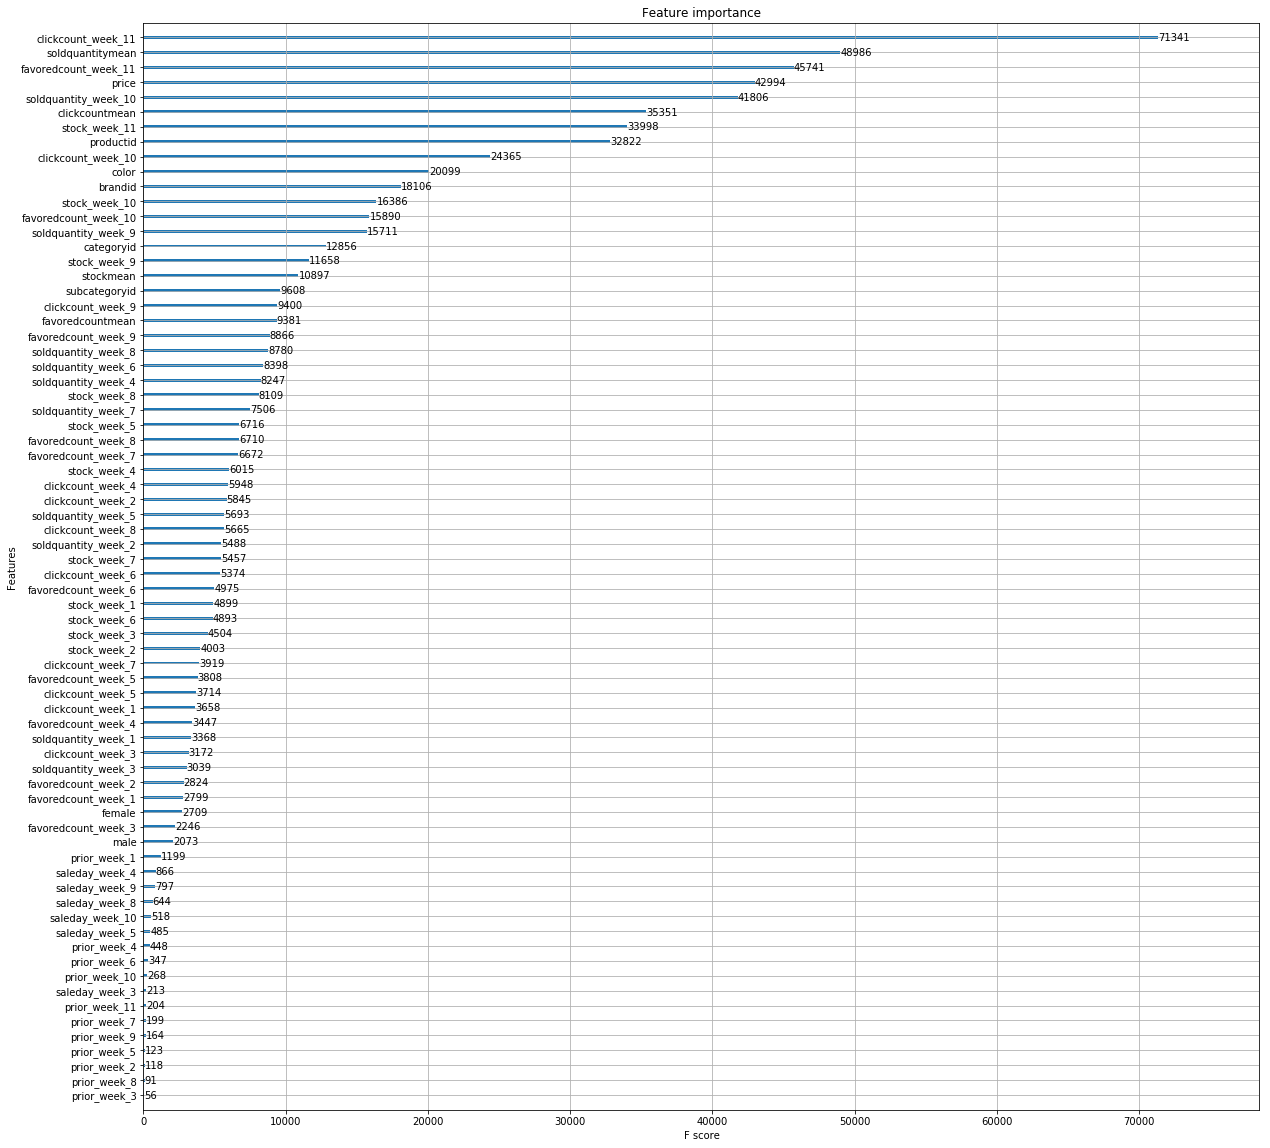

In [27]:
ax = xgb.plot_importance(model)
fig = ax.figure
fig.set_size_inches(20, 20)

### Model Predict 

In [24]:
preds = model.predict(X_test)
preds[preds < 0] = 0

In [25]:
subm = pd.DataFrame()
subm['productid'] = X_test.productid.values
subm['sales'] = preds
subm.to_csv('submission.csv', index=False)